TED Talks transcripts
https://www.kaggle.com/rounakbanik/ted-talks?select=transcripts.csv#

In [13]:
import pandas as pd
import spacy
import numpy as np
import pickle
import re
from sklearn import svm
from scipy.stats import entropy

from sklearn.metrics import *
from matplotlib import pyplot as plt 
from collections import OrderedDict

In [2]:
def load_phonetic_embedding():
    lookup = None
    # read phonetic embedding pickle file
    path = "../data/"
    with open(path+'phonetic_embd.pickle', 'rb') as handle:
        lookup = pickle.load(handle)
    print("Phonetic embedding loaded !")
    return lookup

lookup = load_phonetic_embedding()

len(list(lookup.keys()))

Phonetic embedding loaded !


116514

In [3]:
df = pd.read_csv("../data/TED_transcripts.csv")
df = df["transcript"]
df.head()

0    Good morning. How are you?(Laughter)It's been ...
1    Thank you so much, Chris. And it's truly a gre...
2    (Music: "The Sound of Silence," Simon & Garfun...
3    If you're here today — and I'm very happy that...
4    About 10 years ago, I took on the task to teac...
Name: transcript, dtype: object

In [4]:
df.shape

(2467,)

In [235]:
# Tokenize all documents
nlp = spacy.load("en_core_web_sm")

tokens = []
for talk in df:
    doc = nlp(talk)
    words = []
    for w in doc:
        if w.text.isalpha():
            words.append(w.text.lower())
    words = list(set(words))
    tokens.append(words)
print(len(tokens))

2467


In [236]:
# save TED transcript unique tokens to file
with open('TED_transcript_tokens.npy', 'wb') as f:
    np.save(f, np.array(tokens, dtype=object))

In [14]:
# load saved file
tokens = np.load('TED_transcript_tokens.npy', allow_pickle=True)

In [15]:
# set of unique words among all of the test set
test_words = []
for l in tokens:
    test_words.extend(l)
test_words = list(dict.fromkeys(test_words))
len(test_words)

56989

In [239]:
# returns 1 if word is difficult to say 0 otherwise
# here, we have simulated 5 different users so output will be different for each user
def oracle(word, user):
    if user==0:   # starting with a consonant and then followed by the r sound
        pattern = "^([b-df-hj-np-tv-z])r.*"
    elif user==1:  # starting with st or fl
        pattern = "^(st|fl).*"
    elif user==2:  # r or l letter at second place
        pattern = ".{1}[r|l].*"
    elif user==3:  # anywhere in the word - ch or sc
        pattern = ".*(ch|sc).*"
    elif user==4:  # starting with B,P,D,M,N, and F 
        pattern = "^[bpdmnf].*"
    elif user==5:   # starting with a consonant and then followed by the r sound
        pattern = "^([b-df-hj-np-tv-z])r.*"
    elif user==6:  # starting with st or fl
        pattern = "^(st|fl).*"
    elif user==7:  # r or l letter at second place
        pattern = ".{1}[r|l].*"
    elif user==8:  # anywhere in the word - ch or sc
        pattern = ".*(ch|sc).*"
    elif user==9:  # starting with B,P,D,M,N, and F 
        pattern = "^[bpdmnf].*"
    m = re.match(pattern, word)
    if m:
        start, stop = m.span()
        if stop-start == len(word):
            return 1
    return 0

In [144]:
oracle("school", 3)

1

In [240]:
def random_sampling(X_unlab, seed):
    random.seed(seed)
    return random.choice(X_unlab)

In [266]:
# returns the next most uncertain word by entropy
# @input: clf - classifier, X_unlab - list of words
def uncertainity_sampling(clf, X_unlab):
    X_unlab = [w for w in X_unlab if w.upper() in lookup]
    X = [lookup[w.upper()] for w in X_unlab]
    prob = clf.predict_proba(X)
    ent = entropy(prob.T)
    sorted_ind = (-ent).argsort()[0]
    return X_unlab[sorted_ind]

def clf_predict(clf, words):
    pred = []
    for w in words:
        w = w.upper()
        if w not in lookup:
            pred.append(0)
        else:
            pred.append(clf.predict([lookup[w]])[0])
    return pred

# fit function because not all words are available in lookup
def clf_fit(words, label):
    X, y = [], []
    for w,l in zip(words, label):
        w = w.upper()
        if w in lookup:
            X.append(lookup[w])
            y.append(l)
    clf = svm.SVC(probability=True, random_state=0)
    clf.fit(X, y)
    return clf

In [267]:
# for a given trained classifier - computes different metrics on the test set
def evaluate(clf, X_test, y_test):
    y_pred = clf_predict(clf, X_test)
    pre = precision_score(y_test, y_pred, zero_division=0)*100
    acc = accuracy_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    #print(round(f1,2), "   ",round(acc,2), "    ",round(pre,2))
    return {"precision":pre, "accuracy":acc, "f1":f1, "recall":recall}

In [268]:
def initial_split(i):
    easy, diff = [], []
    #easy = ['a', 'an', 'he', 'she', 'be', 'the', 'cat', 'dog', 'bat', 'mat', 'rat']
    if i==0:   # r sound at second place
        print("consonant followed by r sound")
        easy = ['a', 'an', 'he', 'she']
        diff = ['graph', 'group', 'green', 'grand']
    elif i==1: # st or fl sound to begin
        print("st or fl sound to begin")
        easy = ['the', 'cat', 'dog', 'bat']
        diff = ['street', 'florida', 'straight', 'stutter']
    elif i==2:     # r or l letter at second place
        print("r or l letter at second place")
        easy = ['the', 'a', 'he', 'rat']
        diff = ['crisp', 'crumble', 'alaska', 'close']
    elif i==3:   # ch or sc sound anywhere in the word
        print("sc or ch sound anywhere in the word")
        easy = ['book', 'table', 'cat', 'she']
        diff = ['scold', 'chair', 'beach', 'chase']
    elif i==4:  # words starting with B,P,D,M,N, and F
        print("words starting with B,P,D,M,N, and F")
        easy = ['she', 'a', 'group', 'rat']
        diff = ['packet', 'more', 'nostalgia', 'fish']
    elif i==5:   # r sound at second place
        print("consonant followed by r sound")
        easy = ['packet', 'cat', 'bat', 'she']
        diff = ['crime', 'provost', 'printer', 'crisp']
    elif i==6: # st or fl sound to begin
        print("st or fl sound to begin")
        easy = ['packet', 'more', 'nostalgia', 'fish']
        diff = ['flood', 'flash', 'stay', 'step']
    elif i==7:     # r or l letter at second place
        print("r or l letter at second place")
        easy = ['book', 'table', 'cat', 'she']
        diff = ['graph', 'grand', 'alcohol', 'algebra']
    elif i==8:   # ch or sc sound anywhere in the word
        print("sc or ch sound anywhere in the word")
        easy = ['graph', 'grand', 'alcohol', 'algebra']
        diff = ['scam', 'scan', 'match', 'cheese']
    elif i==9:  # words starting with B,P,D,M,N, and F
        print("words starting with B,P,D,M,N, and F")
        easy = ['scam', 'scan', 'alcohol', 'cheese']
        diff = ['match', 'beauty', 'pen', 'dish']
    #diff = ['graph', 'group', 'trivedi', 'green', 'grand', 'provost', 'crisp', 'grey', 'grill', 'crumble']

    X_lab = easy + diff
    y_lab = [0]*len(easy) + [1]*len(diff)

    X_rem = list(set(test_words) - set(X_lab))

    test_size = int(len(X_rem)*0.25)
    
    X_test = X_rem[len(X_rem)-test_size:]
    y_test = [oracle(w, i) for w in X_test]
    
    X_unlab = X_rem[:len(X_rem)-test_size]
    X_train = X_lab + X_unlab

    #print(len(X_lab), len(X_unlab), len(X_train), len(X_test))
    
    return X_lab, y_lab, X_unlab, X_test, y_test

In [269]:
res = {"imp":[], "exp":[], "ran":[]} 

number_of_queries = 1000
rounds = 10

for r in range(rounds):
    print("Round ", r)
    for strategy in ["exp","imp","ran"]:
        X_lab, y_lab, X_unlab, X_test, y_test = initial_split(r)
        model = clf_fit(X_lab, y_lab)
        #res[strategy][r] = []
        res[strategy].append(evaluate(model, X_test, y_test))

        for i in range(number_of_queries):
                q = None
                if strategy=="imp":
                    q = X_unlab[0]
                elif strategy=="exp":
                    q = uncertainity_sampling(model, X_unlab)
                elif strategy=="ran":
                    q = random_sampling(X_unlab, r*i)

                X_lab.append(q)
                y_lab.append(oracle(q, r))
                X_unlab = list(set(X_unlab)-set([q]))
                model = clf_fit(X_lab, y_lab)
                print("Query: ", i+1, " word: ", q, "  label: ",oracle(q, r))
                res[strategy].append(evaluate(model, X_test, y_test))    

Round  0
consonant followed by r sound
Query:  1  word:  signifying   label:  0
Query:  2  word:  bride   label:  1
Query:  3  word:  drivers   label:  1
Query:  4  word:  windchill   label:  0
Query:  5  word:  crooked   label:  1
Query:  6  word:  uh   label:  0
Query:  7  word:  grazing   label:  1
Query:  8  word:  temp   label:  0
Query:  9  word:  irrigate   label:  0
Query:  10  word:  lineup   label:  0
Query:  11  word:  pritchard   label:  1
Query:  12  word:  pregnancy   label:  1
Query:  13  word:  responsibilities   label:  0
Query:  14  word:  curbs   label:  0
Query:  15  word:  clearances   label:  0
Query:  16  word:  prefect   label:  1
Query:  17  word:  ignition   label:  0
Query:  18  word:  bloodworth   label:  0
Query:  19  word:  northerners   label:  0
Query:  20  word:  torch   label:  0
Query:  21  word:  gravitating   label:  1
Query:  22  word:  prided   label:  1
Query:  23  word:  congratulated   label:  0
Query:  24  word:  disguise   label:  0
Query:  2

Query:  204  word:  prospectors   label:  1
Query:  205  word:  predispositions   label:  1
Query:  206  word:  thru   label:  0
Query:  207  word:  beautifully   label:  0
Query:  208  word:  braaten   label:  1
Query:  209  word:  cuisines   label:  0
Query:  210  word:  freaky   label:  1
Query:  211  word:  unprepared   label:  0
Query:  212  word:  clearest   label:  0
Query:  213  word:  karp   label:  0
Query:  214  word:  crocodiles   label:  1
Query:  215  word:  bugles   label:  0
Query:  216  word:  tricked   label:  1
Query:  217  word:  postal   label:  0
Query:  218  word:  concubine   label:  0
Query:  219  word:  bearden   label:  0
Query:  220  word:  translation   label:  1
Query:  221  word:  trustee   label:  1
Query:  222  word:  sultry   label:  0
Query:  223  word:  trackers   label:  1
Query:  224  word:  floodgates   label:  0
Query:  225  word:  bringing   label:  1
Query:  226  word:  breastplate   label:  1
Query:  227  word:  trophy   label:  1
Query:  228 

Query:  402  word:  parchment   label:  0
Query:  403  word:  platforms   label:  0
Query:  404  word:  quandaries   label:  0
Query:  405  word:  cuisinart   label:  0
Query:  406  word:  khmer   label:  0
Query:  407  word:  retrievers   label:  0
Query:  408  word:  threes   label:  0
Query:  409  word:  prague   label:  1
Query:  410  word:  treasured   label:  1
Query:  411  word:  shorthand   label:  0
Query:  412  word:  parkes   label:  0
Query:  413  word:  gravitates   label:  1
Query:  414  word:  troubling   label:  1
Query:  415  word:  parkin   label:  0
Query:  416  word:  professionalized   label:  1
Query:  417  word:  schnauzer   label:  0
Query:  418  word:  transection   label:  1
Query:  419  word:  congressional   label:  0
Query:  420  word:  cavorting   label:  0
Query:  421  word:  proxy   label:  1
Query:  422  word:  club   label:  0
Query:  423  word:  kilograms   label:  0
Query:  424  word:  groopman   label:  1
Query:  425  word:  brotherhood   label:  1


Query:  598  word:  proliferating   label:  1
Query:  599  word:  treachery   label:  1
Query:  600  word:  frequency   label:  1
Query:  601  word:  matriarch   label:  0
Query:  602  word:  freaked   label:  1
Query:  603  word:  bankrolled   label:  0
Query:  604  word:  forcible   label:  0
Query:  605  word:  proclaiming   label:  1
Query:  606  word:  secreted   label:  0
Query:  607  word:  sprinters   label:  0
Query:  608  word:  crosswise   label:  1
Query:  609  word:  twirl   label:  0
Query:  610  word:  curator   label:  0
Query:  611  word:  citrus   label:  0
Query:  612  word:  trashy   label:  1
Query:  613  word:  cretaceous   label:  1
Query:  614  word:  gravesite   label:  1
Query:  615  word:  guards   label:  0
Query:  616  word:  prefer   label:  1
Query:  617  word:  grandkids   label:  1
Query:  618  word:  pluses   label:  0
Query:  619  word:  chlorophyll   label:  0
Query:  620  word:  precursors   label:  1
Query:  621  word:  concerti   label:  0
Query: 

Query:  794  word:  pressuring   label:  1
Query:  795  word:  gantry   label:  0
Query:  796  word:  fritz   label:  1
Query:  797  word:  quadra   label:  0
Query:  798  word:  dropping   label:  1
Query:  799  word:  confucianism   label:  0
Query:  800  word:  depression   label:  0
Query:  801  word:  contrasting   label:  0
Query:  802  word:  trickled   label:  1
Query:  803  word:  propositions   label:  1
Query:  804  word:  blasphemy   label:  0
Query:  805  word:  grasshopper   label:  1
Query:  806  word:  sharpen   label:  0
Query:  807  word:  fret   label:  1
Query:  808  word:  disgrace   label:  0
Query:  809  word:  treatise   label:  1
Query:  810  word:  creation   label:  1
Query:  811  word:  barber   label:  0
Query:  812  word:  broiling   label:  1
Query:  813  word:  premiums   label:  1
Query:  814  word:  proposes   label:  1
Query:  815  word:  temperatures   label:  0
Query:  816  word:  fraternize   label:  1
Query:  817  word:  porpoise   label:  0
Query

Query:  991  word:  provocatively   label:  1
Query:  992  word:  downgrade   label:  0
Query:  993  word:  thrice   label:  0
Query:  994  word:  traditionally   label:  1
Query:  995  word:  daydreaming   label:  0
Query:  996  word:  frowned   label:  1
Query:  997  word:  crannies   label:  1
Query:  998  word:  frankenstein   label:  1
Query:  999  word:  crank   label:  1
Query:  1000  word:  farfetched   label:  0
consonant followed by r sound
Query:  1  word:  prefect   label:  1
Query:  2  word:  calibrate   label:  0
Query:  3  word:  perhaps   label:  0
Query:  4  word:  katrin   label:  0
Query:  5  word:  locks   label:  0
Query:  6  word:  napster   label:  0
Query:  7  word:  spearhead   label:  0
Query:  8  word:  withdrawn   label:  0
Query:  9  word:  blanchett   label:  0
Query:  10  word:  milieu   label:  0
Query:  11  word:  talkative   label:  0
Query:  12  word:  follow   label:  0
Query:  13  word:  killings   label:  0
Query:  14  word:  ulcers   label:  0
Que

Query:  194  word:  shouldering   label:  0
Query:  195  word:  disintegrates   label:  0
Query:  196  word:  gyri   label:  0
Query:  197  word:  causation   label:  0
Query:  198  word:  enforce   label:  0
Query:  199  word:  approximation   label:  0
Query:  200  word:  surfings   label:  0
Query:  201  word:  backup   label:  0
Query:  202  word:  sanitize   label:  0
Query:  203  word:  patna   label:  0
Query:  204  word:  tutus   label:  0
Query:  205  word:  undies   label:  0
Query:  206  word:  handguns   label:  0
Query:  207  word:  textiles   label:  0
Query:  208  word:  meld   label:  0
Query:  209  word:  offenses   label:  0
Query:  210  word:  retrained   label:  0
Query:  211  word:  agloe   label:  0
Query:  212  word:  cilantro   label:  0
Query:  213  word:  contribution   label:  0
Query:  214  word:  soapstone   label:  0
Query:  215  word:  julius   label:  0
Query:  216  word:  interpenetrating   label:  0
Query:  217  word:  dizziness   label:  0
Query:  218

Query:  395  word:  attendants   label:  0
Query:  396  word:  taboos   label:  0
Query:  397  word:  mullen   label:  0
Query:  398  word:  encapsulates   label:  0
Query:  399  word:  assignment   label:  0
Query:  400  word:  fretful   label:  1
Query:  401  word:  yusor   label:  0
Query:  402  word:  ravana   label:  0
Query:  403  word:  bowden   label:  0
Query:  404  word:  strapped   label:  0
Query:  405  word:  outbox   label:  0
Query:  406  word:  putter   label:  0
Query:  407  word:  ulay   label:  0
Query:  408  word:  bag   label:  0
Query:  409  word:  benevolence   label:  0
Query:  410  word:  unconfirmed   label:  0
Query:  411  word:  wentit   label:  0
Query:  412  word:  epitrochlear   label:  0
Query:  413  word:  cambodian   label:  0
Query:  414  word:  embraces   label:  0
Query:  415  word:  warehousing   label:  0
Query:  416  word:  buttock   label:  0
Query:  417  word:  stinkier   label:  0
Query:  418  word:  temporality   label:  0
Query:  419  word: 

Query:  597  word:  banana   label:  0
Query:  598  word:  edits   label:  0
Query:  599  word:  photosynth   label:  0
Query:  600  word:  rangers   label:  0
Query:  601  word:  undeniably   label:  0
Query:  602  word:  trouser   label:  1
Query:  603  word:  bierstadt   label:  0
Query:  604  word:  stronger   label:  0
Query:  605  word:  lookin   label:  0
Query:  606  word:  indications   label:  0
Query:  607  word:  anode   label:  0
Query:  608  word:  opto   label:  0
Query:  609  word:  bouman   label:  0
Query:  610  word:  offshoot   label:  0
Query:  611  word:  ego   label:  0
Query:  612  word:  suspensions   label:  0
Query:  613  word:  galaxies   label:  0
Query:  614  word:  dehydration   label:  0
Query:  615  word:  mwinyi   label:  0
Query:  616  word:  instilled   label:  0
Query:  617  word:  clattering   label:  0
Query:  618  word:  seals   label:  0
Query:  619  word:  urbanspoon   label:  0
Query:  620  word:  dons   label:  0
Query:  621  word:  tillie   

Query:  798  word:  hopkin   label:  0
Query:  799  word:  few   label:  0
Query:  800  word:  moskowitz   label:  0
Query:  801  word:  navajo   label:  0
Query:  802  word:  okonkwo   label:  0
Query:  803  word:  triassic   label:  1
Query:  804  word:  cheeks   label:  0
Query:  805  word:  tron   label:  1
Query:  806  word:  underpinned   label:  0
Query:  807  word:  whooo   label:  0
Query:  808  word:  doit   label:  0
Query:  809  word:  replicating   label:  0
Query:  810  word:  tbl   label:  0
Query:  811  word:  ballbots   label:  0
Query:  812  word:  simple   label:  0
Query:  813  word:  cereal   label:  0
Query:  814  word:  bluey   label:  0
Query:  815  word:  spina   label:  0
Query:  816  word:  sumner   label:  0
Query:  817  word:  reaching   label:  0
Query:  818  word:  dipsticks   label:  0
Query:  819  word:  egotist   label:  0
Query:  820  word:  rutans   label:  0
Query:  821  word:  compatriots   label:  0
Query:  822  word:  fed   label:  0
Query:  823 

Query:  999  word:  donahue   label:  0
Query:  1000  word:  haile   label:  0
consonant followed by r sound
Query:  1  word:  pond   label:  0
Query:  2  word:  freckled   label:  1
Query:  3  word:  fingertips   label:  0
Query:  4  word:  plunder   label:  0
Query:  5  word:  texting   label:  0
Query:  6  word:  residencies   label:  0
Query:  7  word:  juniper   label:  0
Query:  8  word:  roulette   label:  0
Query:  9  word:  revamping   label:  0
Query:  10  word:  beautified   label:  0
Query:  11  word:  handing   label:  0
Query:  12  word:  droughts   label:  1
Query:  13  word:  seaand   label:  0
Query:  14  word:  stucco   label:  0
Query:  15  word:  diametrically   label:  0
Query:  16  word:  caricaturing   label:  0
Query:  17  word:  toxicities   label:  0
Query:  18  word:  careened   label:  0
Query:  19  word:  armstrong   label:  0
Query:  20  word:  inverts   label:  0
Query:  21  word:  oxygenated   label:  0
Query:  22  word:  determinism   label:  0
Query:  

Query:  202  word:  salmon   label:  0
Query:  203  word:  patek   label:  0
Query:  204  word:  bailout   label:  0
Query:  205  word:  chamber   label:  0
Query:  206  word:  bypassed   label:  0
Query:  207  word:  chevy   label:  0
Query:  208  word:  talknophical   label:  0
Query:  209  word:  classicist   label:  0
Query:  210  word:  filmclub   label:  0
Query:  211  word:  kabob   label:  0
Query:  212  word:  indonesians   label:  0
Query:  213  word:  confucius   label:  0
Query:  214  word:  majora   label:  0
Query:  215  word:  kacey   label:  0
Query:  216  word:  sergey   label:  0
Query:  217  word:  villatoro   label:  0
Query:  218  word:  airbags   label:  0
Query:  219  word:  fingerprints   label:  0
Query:  220  word:  renminbi   label:  0
Query:  221  word:  sexter   label:  0
Query:  222  word:  advancements   label:  0
Query:  223  word:  borrow   label:  0
Query:  224  word:  technophobe   label:  0
Query:  225  word:  sexual   label:  0
Query:  226  word:  a

Query:  404  word:  gaffer   label:  0
Query:  405  word:  bayridge   label:  0
Query:  406  word:  telegenic   label:  0
Query:  407  word:  rebelled   label:  0
Query:  408  word:  thermometers   label:  0
Query:  409  word:  breakbone   label:  1
Query:  410  word:  lastly   label:  0
Query:  411  word:  decimals   label:  0
Query:  412  word:  deceased   label:  0
Query:  413  word:  resonances   label:  0
Query:  414  word:  yay   label:  0
Query:  415  word:  airtight   label:  0
Query:  416  word:  avoidance   label:  0
Query:  417  word:  adventurous   label:  0
Query:  418  word:  misdirection   label:  0
Query:  419  word:  biology   label:  0
Query:  420  word:  monstrosities   label:  0
Query:  421  word:  reconsideration   label:  0
Query:  422  word:  oakley   label:  0
Query:  423  word:  hooted   label:  0
Query:  424  word:  bigot   label:  0
Query:  425  word:  tackling   label:  0
Query:  426  word:  vanishingly   label:  0
Query:  427  word:  woeful   label:  0
Quer

Query:  605  word:  afsluitdijk   label:  0
Query:  606  word:  colonnade   label:  0
Query:  607  word:  neo   label:  0
Query:  608  word:  reebok   label:  0
Query:  609  word:  proprietary   label:  1
Query:  610  word:  qualm   label:  0
Query:  611  word:  adolph   label:  0
Query:  612  word:  concert   label:  0
Query:  613  word:  drizzling   label:  1
Query:  614  word:  elio   label:  0
Query:  615  word:  inefficient   label:  0
Query:  616  word:  preschool   label:  1
Query:  617  word:  guacamole   label:  0
Query:  618  word:  outed   label:  0
Query:  619  word:  nobu   label:  0
Query:  620  word:  cricketers   label:  1
Query:  621  word:  uniforms   label:  0
Query:  622  word:  meander   label:  0
Query:  623  word:  duany   label:  0
Query:  624  word:  adrenalin   label:  0
Query:  625  word:  exceptionalism   label:  0
Query:  626  word:  multiplying   label:  0
Query:  627  word:  hunan   label:  0
Query:  628  word:  kobe   label:  0
Query:  629  word:  reliab

Query:  805  word:  functionary   label:  0
Query:  806  word:  cochrane   label:  0
Query:  807  word:  bestraddled   label:  0
Query:  808  word:  pcs   label:  0
Query:  809  word:  pickup   label:  0
Query:  810  word:  validate   label:  0
Query:  811  word:  annabelle   label:  0
Query:  812  word:  mariam   label:  0
Query:  813  word:  excruciating   label:  0
Query:  814  word:  hubcaps   label:  0
Query:  815  word:  inventive   label:  0
Query:  816  word:  territory   label:  0
Query:  817  word:  karstic   label:  0
Query:  818  word:  palais   label:  0
Query:  819  word:  roar   label:  0
Query:  820  word:  tuskegee   label:  0
Query:  821  word:  ekg   label:  0
Query:  822  word:  favors   label:  0
Query:  823  word:  gaudi   label:  0
Query:  824  word:  xyz   label:  0
Query:  825  word:  guttmacher   label:  0
Query:  826  word:  livability   label:  0
Query:  827  word:  trailer   label:  1
Query:  828  word:  pitchpole   label:  0
Query:  829  word:  indicted   

Query:  5  word:  fifteenth   label:  0
Query:  6  word:  suckle   label:  0
Query:  7  word:  strait   label:  1
Query:  8  word:  retrograde   label:  0
Query:  9  word:  stapleton   label:  1
Query:  10  word:  listed   label:  0
Query:  11  word:  strode   label:  1
Query:  12  word:  zanzibar   label:  0
Query:  13  word:  frustrating   label:  0
Query:  14  word:  dates   label:  0
Query:  15  word:  entranced   label:  0
Query:  16  word:  angeles   label:  0
Query:  17  word:  strobe   label:  1
Query:  18  word:  airstrip   label:  0
Query:  19  word:  stab   label:  1
Query:  20  word:  style   label:  1
Query:  21  word:  spiel   label:  0
Query:  22  word:  stringer   label:  1
Query:  23  word:  stella   label:  1
Query:  24  word:  slain   label:  0
Query:  25  word:  lifestyles   label:  0
Query:  26  word:  scripts   label:  0
Query:  27  word:  stump   label:  1
Query:  28  word:  strangler   label:  1
Query:  29  word:  parched   label:  0
Query:  30  word:  nutter   

Query:  209  word:  rates   label:  0
Query:  210  word:  staffers   label:  1
Query:  211  word:  storefronts   label:  1
Query:  212  word:  statistician   label:  1
Query:  213  word:  scorching   label:  0
Query:  214  word:  substantiated   label:  0
Query:  215  word:  trusting   label:  0
Query:  216  word:  slopes   label:  0
Query:  217  word:  stockhausen   label:  1
Query:  218  word:  scandals   label:  0
Query:  219  word:  speedy   label:  0
Query:  220  word:  shtick   label:  0
Query:  221  word:  sterility   label:  1
Query:  222  word:  scum   label:  0
Query:  223  word:  foxtrot   label:  0
Query:  224  word:  deconstruction   label:  0
Query:  225  word:  scarcer   label:  0
Query:  226  word:  feuerstein   label:  0
Query:  227  word:  lichty   label:  0
Query:  228  word:  stutters   label:  1
Query:  229  word:  stairwells   label:  1
Query:  230  word:  tricksters   label:  0
Query:  231  word:  strickland   label:  1
Query:  232  word:  stroking   label:  1
Qu

Query:  408  word:  stutzman   label:  1
Query:  409  word:  fixture   label:  0
Query:  410  word:  substitutes   label:  0
Query:  411  word:  strategize   label:  1
Query:  412  word:  staking   label:  1
Query:  413  word:  syndicates   label:  0
Query:  414  word:  servants   label:  0
Query:  415  word:  storytelling   label:  1
Query:  416  word:  screenwriting   label:  0
Query:  417  word:  snapshot   label:  0
Query:  418  word:  stillness   label:  1
Query:  419  word:  slider   label:  0
Query:  420  word:  subordinates   label:  0
Query:  421  word:  touchstone   label:  0
Query:  422  word:  standardize   label:  1
Query:  423  word:  federalists   label:  0
Query:  424  word:  sweats   label:  0
Query:  425  word:  steiner   label:  1
Query:  426  word:  stalled   label:  1
Query:  427  word:  structurally   label:  1
Query:  428  word:  stakeout   label:  1
Query:  429  word:  stalking   label:  1
Query:  430  word:  stymies   label:  1
Query:  431  word:  stifler   lab

Query:  608  word:  snapping   label:  0
Query:  609  word:  scotland   label:  0
Query:  610  word:  silvestro   label:  0
Query:  611  word:  slogan   label:  0
Query:  612  word:  startles   label:  1
Query:  613  word:  steaming   label:  1
Query:  614  word:  outstripping   label:  0
Query:  615  word:  speeding   label:  0
Query:  616  word:  strasburg   label:  1
Query:  617  word:  schwartzberg   label:  0
Query:  618  word:  fraudsters   label:  0
Query:  619  word:  stasi   label:  1
Query:  620  word:  stepfather   label:  1
Query:  621  word:  steppes   label:  1
Query:  622  word:  tse   label:  0
Query:  623  word:  statues   label:  1
Query:  624  word:  thermostats   label:  0
Query:  625  word:  stroman   label:  1
Query:  626  word:  fats   label:  0
Query:  627  word:  stylistic   label:  1
Query:  628  word:  struthers   label:  1
Query:  629  word:  trouser   label:  0
Query:  630  word:  slanders   label:  0
Query:  631  word:  lipschitz   label:  0
Query:  632  w

Query:  808  word:  stockwell   label:  1
Query:  809  word:  sloppily   label:  0
Query:  810  word:  circulates   label:  0
Query:  811  word:  fantasia   label:  0
Query:  812  word:  spans   label:  0
Query:  813  word:  soundtrack   label:  0
Query:  814  word:  substitute   label:  0
Query:  815  word:  fretful   label:  0
Query:  816  word:  schedules   label:  0
Query:  817  word:  schultes   label:  0
Query:  818  word:  slung   label:  0
Query:  819  word:  scout   label:  0
Query:  820  word:  tablespoons   label:  0
Query:  821  word:  sunspots   label:  0
Query:  822  word:  surname   label:  0
Query:  823  word:  reintroduction   label:  0
Query:  824  word:  fictions   label:  0
Query:  825  word:  retorted   label:  0
Query:  826  word:  serviced   label:  0
Query:  827  word:  skinny   label:  0
Query:  828  word:  sightsee   label:  0
Query:  829  word:  slips   label:  0
Query:  830  word:  texting   label:  0
Query:  831  word:  demonstration   label:  0
Query:  832

Query:  9  word:  blanchett   label:  0
Query:  10  word:  milieu   label:  0
Query:  11  word:  talkative   label:  0
Query:  12  word:  follow   label:  0
Query:  13  word:  killings   label:  0
Query:  14  word:  ulcers   label:  0
Query:  15  word:  deforestation   label:  0
Query:  16  word:  malorum   label:  0
Query:  17  word:  photojournalism   label:  0
Query:  18  word:  fresher   label:  0
Query:  19  word:  plankton   label:  0
Query:  20  word:  tsukuru   label:  0
Query:  21  word:  appended   label:  0
Query:  22  word:  tenerife   label:  0
Query:  23  word:  kiwanians   label:  0
Query:  24  word:  vannevar   label:  0
Query:  25  word:  largest   label:  0
Query:  26  word:  ariva   label:  0
Query:  27  word:  cumbersome   label:  0
Query:  28  word:  plantoid   label:  0
Query:  29  word:  cocaine   label:  0
Query:  30  word:  serbian   label:  0
Query:  31  word:  cynics   label:  0
Query:  32  word:  waydans   label:  0
Query:  33  word:  squeezer   label:  0
Qu

Query:  213  word:  contribution   label:  0
Query:  214  word:  soapstone   label:  0
Query:  215  word:  julius   label:  0
Query:  216  word:  interpenetrating   label:  0
Query:  217  word:  dizziness   label:  0
Query:  218  word:  encrypting   label:  0
Query:  219  word:  scarab   label:  0
Query:  220  word:  gearbox   label:  0
Query:  221  word:  mortally   label:  0
Query:  222  word:  cafetorium   label:  0
Query:  223  word:  rattling   label:  0
Query:  224  word:  tableand   label:  0
Query:  225  word:  buterin   label:  0
Query:  226  word:  cavitation   label:  0
Query:  227  word:  isaf   label:  0
Query:  228  word:  microlouver   label:  0
Query:  229  word:  crummy   label:  0
Query:  230  word:  percolating   label:  0
Query:  231  word:  uncorrected   label:  0
Query:  232  word:  eisner   label:  0
Query:  233  word:  acoustician   label:  0
Query:  234  word:  pug   label:  0
Query:  235  word:  crowing   label:  0
Query:  236  word:  malawi   label:  0
Query:

Query:  414  word:  embraces   label:  0
Query:  415  word:  warehousing   label:  0
Query:  416  word:  buttock   label:  0
Query:  417  word:  stinkier   label:  1
Query:  418  word:  temporality   label:  0
Query:  419  word:  bulldozing   label:  0
Query:  420  word:  decomposed   label:  0
Query:  421  word:  watching   label:  0
Query:  422  word:  kenji   label:  0
Query:  423  word:  muppet   label:  0
Query:  424  word:  zabbaleen   label:  0
Query:  425  word:  legend   label:  0
Query:  426  word:  advertiser   label:  0
Query:  427  word:  american   label:  0
Query:  428  word:  chips   label:  0
Query:  429  word:  trail   label:  0
Query:  430  word:  plausibility   label:  0
Query:  431  word:  lome   label:  0
Query:  432  word:  replicability   label:  0
Query:  433  word:  upsetting   label:  0
Query:  434  word:  treachery   label:  0
Query:  435  word:  parapet   label:  0
Query:  436  word:  dane   label:  0
Query:  437  word:  kimble   label:  0
Query:  438  word

Query:  616  word:  instilled   label:  0
Query:  617  word:  clattering   label:  0
Query:  618  word:  seals   label:  0
Query:  619  word:  urbanspoon   label:  0
Query:  620  word:  dons   label:  0
Query:  621  word:  tillie   label:  0
Query:  622  word:  gains   label:  0
Query:  623  word:  insemination   label:  0
Query:  624  word:  lesotho   label:  0
Query:  625  word:  lindelof   label:  0
Query:  626  word:  erroneously   label:  0
Query:  627  word:  abnormally   label:  0
Query:  628  word:  mahabuba   label:  0
Query:  629  word:  compartment   label:  0
Query:  630  word:  puliafito   label:  0
Query:  631  word:  owing   label:  0
Query:  632  word:  robopocalypse   label:  0
Query:  633  word:  recovers   label:  0
Query:  634  word:  complimenting   label:  0
Query:  635  word:  lytic   label:  0
Query:  636  word:  composition   label:  0
Query:  637  word:  ninja   label:  0
Query:  638  word:  grove   label:  0
Query:  639  word:  modest   label:  0
Query:  640 

Query:  818  word:  dipsticks   label:  0
Query:  819  word:  egotist   label:  0
Query:  820  word:  rutans   label:  0
Query:  821  word:  compatriots   label:  0
Query:  822  word:  fed   label:  0
Query:  823  word:  mauritius   label:  0
Query:  824  word:  jang   label:  0
Query:  825  word:  canopied   label:  0
Query:  826  word:  freelance   label:  0
Query:  827  word:  necropsy   label:  0
Query:  828  word:  stilting   label:  1
Query:  829  word:  shrills   label:  0
Query:  830  word:  beckons   label:  0
Query:  831  word:  spinvox   label:  0
Query:  832  word:  mullainathan   label:  0
Query:  833  word:  liberated   label:  0
Query:  834  word:  totin   label:  0
Query:  835  word:  essentialize   label:  0
Query:  836  word:  mediates   label:  0
Query:  837  word:  nipples   label:  0
Query:  838  word:  surest   label:  0
Query:  839  word:  enslavement   label:  0
Query:  840  word:  buffing   label:  0
Query:  841  word:  lestari   label:  0
Query:  842  word:  p

Query:  18  word:  toll   label:  0
Query:  19  word:  hullabaloo   label:  0
Query:  20  word:  linear   label:  0
Query:  21  word:  woshurettos   label:  0
Query:  22  word:  sate   label:  0
Query:  23  word:  serbia   label:  0
Query:  24  word:  declaring   label:  0
Query:  25  word:  seep   label:  0
Query:  26  word:  bartók   label:  0
Query:  27  word:  acrid   label:  0
Query:  28  word:  identified   label:  0
Query:  29  word:  piezoelectronic   label:  0
Query:  30  word:  ngos   label:  0
Query:  31  word:  hoodwinked   label:  0
Query:  32  word:  tron   label:  0
Query:  33  word:  ow   label:  0
Query:  34  word:  watney   label:  0
Query:  35  word:  coliforms   label:  0
Query:  36  word:  brig   label:  0
Query:  37  word:  reverence   label:  0
Query:  38  word:  afa   label:  0
Query:  39  word:  greece   label:  0
Query:  40  word:  graphics   label:  0
Query:  41  word:  disappearing   label:  0
Query:  42  word:  firemen   label:  0
Query:  43  word:  localiz

Query:  222  word:  militants   label:  0
Query:  223  word:  edginess   label:  0
Query:  224  word:  axises   label:  0
Query:  225  word:  backfire   label:  0
Query:  226  word:  pointer   label:  0
Query:  227  word:  pati   label:  0
Query:  228  word:  queuing   label:  0
Query:  229  word:  diatoms   label:  0
Query:  230  word:  excrement   label:  0
Query:  231  word:  trampled   label:  0
Query:  232  word:  priya   label:  0
Query:  233  word:  bridging   label:  0
Query:  234  word:  defiling   label:  0
Query:  235  word:  revelations   label:  0
Query:  236  word:  google   label:  0
Query:  237  word:  hallowed   label:  0
Query:  238  word:  duplicate   label:  0
Query:  239  word:  pursuers   label:  0
Query:  240  word:  tons   label:  0
Query:  241  word:  avalanche   label:  0
Query:  242  word:  conversing   label:  0
Query:  243  word:  truss   label:  0
Query:  244  word:  autodesk   label:  0
Query:  245  word:  tactually   label:  0
Query:  246  word:  korea  

Query:  422  word:  counted   label:  0
Query:  423  word:  antarctica   label:  0
Query:  424  word:  wet   label:  0
Query:  425  word:  righty   label:  0
Query:  426  word:  sore   label:  0
Query:  427  word:  preferably   label:  0
Query:  428  word:  sexiest   label:  0
Query:  429  word:  mashable   label:  0
Query:  430  word:  sequence   label:  0
Query:  431  word:  paisley   label:  0
Query:  432  word:  inducement   label:  0
Query:  433  word:  tarp   label:  0
Query:  434  word:  physiocrats   label:  0
Query:  435  word:  nezar   label:  0
Query:  436  word:  khota   label:  0
Query:  437  word:  craved   label:  0
Query:  438  word:  howey   label:  0
Query:  439  word:  believers   label:  0
Query:  440  word:  scene   label:  0
Query:  441  word:  accommodates   label:  0
Query:  442  word:  presence   label:  0
Query:  443  word:  pm   label:  0
Query:  444  word:  épuise   label:  0
Query:  445  word:  arresting   label:  0
Query:  446  word:  elf   label:  0
Query

Query:  623  word:  roo   label:  0
Query:  624  word:  fingernails   label:  0
Query:  625  word:  gametes   label:  0
Query:  626  word:  noninfectious   label:  0
Query:  627  word:  itching   label:  0
Query:  628  word:  steven   label:  1
Query:  629  word:  demoing   label:  0
Query:  630  word:  subjectively   label:  0
Query:  631  word:  terrorists   label:  0
Query:  632  word:  professional   label:  0
Query:  633  word:  christendom   label:  0
Query:  634  word:  bolte   label:  0
Query:  635  word:  impolitely   label:  0
Query:  636  word:  evaporating   label:  0
Query:  637  word:  crackers   label:  0
Query:  638  word:  peta   label:  0
Query:  639  word:  stems   label:  1
Query:  640  word:  phasing   label:  0
Query:  641  word:  blogger   label:  0
Query:  642  word:  untruth   label:  0
Query:  643  word:  collects   label:  0
Query:  644  word:  nonprofessionals   label:  0
Query:  645  word:  bring   label:  0
Query:  646  word:  viewings   label:  0
Query:  

Query:  823  word:  pneumococcus   label:  0
Query:  824  word:  stalking   label:  1
Query:  825  word:  couplets   label:  0
Query:  826  word:  mouthfeel   label:  0
Query:  827  word:  evita   label:  0
Query:  828  word:  emmet   label:  0
Query:  829  word:  bellotto   label:  0
Query:  830  word:  mending   label:  0
Query:  831  word:  roundtable   label:  0
Query:  832  word:  unavailable   label:  0
Query:  833  word:  percentiles   label:  0
Query:  834  word:  members   label:  0
Query:  835  word:  previously   label:  0
Query:  836  word:  flak   label:  1
Query:  837  word:  reuse   label:  0
Query:  838  word:  absences   label:  0
Query:  839  word:  crutzen   label:  0
Query:  840  word:  bamum   label:  0
Query:  841  word:  obliterate   label:  0
Query:  842  word:  advent   label:  0
Query:  843  word:  unelected   label:  0
Query:  844  word:  fitment   label:  0
Query:  845  word:  squeaked   label:  0
Query:  846  word:  chattopadhyaya   label:  0
Query:  847  w

Query:  24  word:  cardiovascular   label:  0
Query:  25  word:  crusade   label:  1
Query:  26  word:  fixes   label:  0
Query:  27  word:  calibrate   label:  0
Query:  28  word:  dreamers   label:  1
Query:  29  word:  glanced   label:  1
Query:  30  word:  tracked   label:  1
Query:  31  word:  blasphemous   label:  1
Query:  32  word:  breastfed   label:  1
Query:  33  word:  proves   label:  1
Query:  34  word:  guam   label:  0
Query:  35  word:  commandments   label:  0
Query:  36  word:  burglaries   label:  0
Query:  37  word:  emerged   label:  0
Query:  38  word:  vortex   label:  0
Query:  39  word:  comprise   label:  0
Query:  40  word:  plexiglas   label:  1
Query:  41  word:  exclude   label:  0
Query:  42  word:  cutest   label:  0
Query:  43  word:  progresses   label:  1
Query:  44  word:  crosswise   label:  1
Query:  45  word:  bradwell   label:  1
Query:  46  word:  broadcasters   label:  1
Query:  47  word:  hertz   label:  0
Query:  48  word:  crusts   label:  

Query:  228  word:  displaces   label:  0
Query:  229  word:  shipwright   label:  0
Query:  230  word:  cuisine   label:  0
Query:  231  word:  kinda   label:  0
Query:  232  word:  treason   label:  1
Query:  233  word:  calculator   label:  0
Query:  234  word:  palpably   label:  0
Query:  235  word:  birthmark   label:  0
Query:  236  word:  bloodletting   label:  1
Query:  237  word:  blueberries   label:  1
Query:  238  word:  brigade   label:  1
Query:  239  word:  filtration   label:  0
Query:  240  word:  precaution   label:  1
Query:  241  word:  trailing   label:  1
Query:  242  word:  presumptions   label:  1
Query:  243  word:  purify   label:  0
Query:  244  word:  disproves   label:  0
Query:  245  word:  basalt   label:  0
Query:  246  word:  adhered   label:  0
Query:  247  word:  treater   label:  1
Query:  248  word:  classically   label:  1
Query:  249  word:  penfield   label:  0
Query:  250  word:  karen   label:  0
Query:  251  word:  creatively   label:  1
Quer

Query:  425  word:  breakout   label:  1
Query:  426  word:  classification   label:  1
Query:  427  word:  firestorm   label:  0
Query:  428  word:  chemistry   label:  0
Query:  429  word:  prohibitions   label:  1
Query:  430  word:  conversations   label:  0
Query:  431  word:  clipping   label:  1
Query:  432  word:  calculate   label:  0
Query:  433  word:  borders   label:  0
Query:  434  word:  congratulatory   label:  0
Query:  435  word:  devastation   label:  0
Query:  436  word:  triggering   label:  1
Query:  437  word:  clientele   label:  1
Query:  438  word:  prosecuting   label:  1
Query:  439  word:  charcoal   label:  0
Query:  440  word:  brochure   label:  1
Query:  441  word:  parachutes   label:  0
Query:  442  word:  barriers   label:  0
Query:  443  word:  burling   label:  0
Query:  444  word:  buckling   label:  0
Query:  445  word:  criticize   label:  1
Query:  446  word:  dearborn   label:  0
Query:  447  word:  transponders   label:  1
Query:  448  word: 

Query:  623  word:  bootstraps   label:  0
Query:  624  word:  bridesmaids   label:  1
Query:  625  word:  friendliness   label:  1
Query:  626  word:  freezer   label:  1
Query:  627  word:  klondike   label:  1
Query:  628  word:  proposes   label:  1
Query:  629  word:  flatter   label:  1
Query:  630  word:  peasantry   label:  0
Query:  631  word:  fletcher   label:  1
Query:  632  word:  cork   label:  0
Query:  633  word:  truthfully   label:  1
Query:  634  word:  terrorized   label:  0
Query:  635  word:  fronts   label:  1
Query:  636  word:  downgraded   label:  0
Query:  637  word:  slammer   label:  1
Query:  638  word:  stringing   label:  0
Query:  639  word:  barbs   label:  0
Query:  640  word:  milgram   label:  0
Query:  641  word:  throughs   label:  0
Query:  642  word:  footrace   label:  0
Query:  643  word:  protuberances   label:  1
Query:  644  word:  shrunk   label:  0
Query:  645  word:  carefree   label:  0
Query:  646  word:  stresses   label:  0
Query:  6

Query:  821  word:  treatments   label:  1
Query:  822  word:  silkworm   label:  0
Query:  823  word:  reprints   label:  0
Query:  824  word:  boyfriends   label:  0
Query:  825  word:  postman   label:  0
Query:  826  word:  technocrats   label:  0
Query:  827  word:  stroll   label:  0
Query:  828  word:  unpleasant   label:  0
Query:  829  word:  slimy   label:  1
Query:  830  word:  shrunken   label:  0
Query:  831  word:  slain   label:  1
Query:  832  word:  unflattering   label:  0
Query:  833  word:  sleeved   label:  1
Query:  834  word:  sprightly   label:  0
Query:  835  word:  prostitutes   label:  1
Query:  836  word:  driveways   label:  1
Query:  837  word:  stringer   label:  0
Query:  838  word:  slice   label:  1
Query:  839  word:  british   label:  1
Query:  840  word:  limb   label:  0
Query:  841  word:  conflates   label:  0
Query:  842  word:  fearful   label:  0
Query:  843  word:  flapper   label:  1
Query:  844  word:  confronting   label:  0
Query:  845  w

Query:  20  word:  tsukuru   label:  0
Query:  21  word:  appended   label:  0
Query:  22  word:  tenerife   label:  0
Query:  23  word:  kiwanians   label:  0
Query:  24  word:  vannevar   label:  0
Query:  25  word:  largest   label:  0
Query:  26  word:  ariva   label:  1
Query:  27  word:  cumbersome   label:  0
Query:  28  word:  plantoid   label:  1
Query:  29  word:  cocaine   label:  0
Query:  30  word:  serbian   label:  0
Query:  31  word:  cynics   label:  0
Query:  32  word:  waydans   label:  0
Query:  33  word:  squeezer   label:  0
Query:  34  word:  scaly   label:  0
Query:  35  word:  cuddles   label:  0
Query:  36  word:  era   label:  1
Query:  37  word:  triumvirate   label:  1
Query:  38  word:  montauk   label:  0
Query:  39  word:  volcanism   label:  0
Query:  40  word:  slag   label:  1
Query:  41  word:  beams   label:  0
Query:  42  word:  kore   label:  0
Query:  43  word:  numbers   label:  0
Query:  44  word:  elliott   label:  1
Query:  45  word:  crested

Query:  223  word:  rattling   label:  0
Query:  224  word:  tableand   label:  0
Query:  225  word:  buterin   label:  0
Query:  226  word:  cavitation   label:  0
Query:  227  word:  isaf   label:  0
Query:  228  word:  microlouver   label:  0
Query:  229  word:  crummy   label:  1
Query:  230  word:  percolating   label:  0
Query:  231  word:  uncorrected   label:  0
Query:  232  word:  eisner   label:  0
Query:  233  word:  acoustician   label:  0
Query:  234  word:  pug   label:  0
Query:  235  word:  crowing   label:  1
Query:  236  word:  malawi   label:  0
Query:  237  word:  trainer   label:  1
Query:  238  word:  noisemaking   label:  0
Query:  239  word:  mainstreaming   label:  0
Query:  240  word:  scrotum   label:  0
Query:  241  word:  misogynists   label:  0
Query:  242  word:  anxious   label:  0
Query:  243  word:  monodramas   label:  0
Query:  244  word:  struvite   label:  0
Query:  245  word:  regurgitate   label:  0
Query:  246  word:  grasshoppers   label:  1
Qu

Query:  424  word:  zabbaleen   label:  0
Query:  425  word:  legend   label:  0
Query:  426  word:  advertiser   label:  0
Query:  427  word:  american   label:  0
Query:  428  word:  chips   label:  0
Query:  429  word:  trail   label:  1
Query:  430  word:  plausibility   label:  1
Query:  431  word:  lome   label:  0
Query:  432  word:  replicability   label:  0
Query:  433  word:  upsetting   label:  0
Query:  434  word:  treachery   label:  1
Query:  435  word:  parapet   label:  0
Query:  436  word:  dane   label:  0
Query:  437  word:  kimble   label:  0
Query:  438  word:  seer   label:  0
Query:  439  word:  padlocks   label:  0
Query:  440  word:  bachelor   label:  0
Query:  441  word:  max   label:  0
Query:  442  word:  iphone   label:  0
Query:  443  word:  yelp   label:  0
Query:  444  word:  wheelie   label:  0
Query:  445  word:  ditches   label:  0
Query:  446  word:  contract   label:  0
Query:  447  word:  negotiated   label:  0
Query:  448  word:  reinstated   lab

Query:  626  word:  erroneously   label:  1
Query:  627  word:  abnormally   label:  0
Query:  628  word:  mahabuba   label:  0
Query:  629  word:  compartment   label:  0
Query:  630  word:  puliafito   label:  0
Query:  631  word:  owing   label:  0
Query:  632  word:  robopocalypse   label:  0
Query:  633  word:  recovers   label:  0
Query:  634  word:  complimenting   label:  0
Query:  635  word:  lytic   label:  0
Query:  636  word:  composition   label:  0
Query:  637  word:  ninja   label:  0
Query:  638  word:  grove   label:  1
Query:  639  word:  modest   label:  0
Query:  640  word:  psychographic   label:  0
Query:  641  word:  appalachian   label:  0
Query:  642  word:  premonition   label:  1
Query:  643  word:  brooks   label:  1
Query:  644  word:  barbaric   label:  0
Query:  645  word:  stimulant   label:  0
Query:  646  word:  jane   label:  0
Query:  647  word:  hannibal   label:  0
Query:  648  word:  impurities   label:  0
Query:  649  word:  rueben   label:  0
Qu

Query:  828  word:  stilting   label:  0
Query:  829  word:  shrills   label:  0
Query:  830  word:  beckons   label:  0
Query:  831  word:  spinvox   label:  0
Query:  832  word:  mullainathan   label:  0
Query:  833  word:  liberated   label:  0
Query:  834  word:  totin   label:  0
Query:  835  word:  essentialize   label:  0
Query:  836  word:  mediates   label:  0
Query:  837  word:  nipples   label:  0
Query:  838  word:  surest   label:  0
Query:  839  word:  enslavement   label:  0
Query:  840  word:  buffing   label:  0
Query:  841  word:  lestari   label:  0
Query:  842  word:  pulverizing   label:  0
Query:  843  word:  humps   label:  0
Query:  844  word:  layar   label:  0
Query:  845  word:  courtrooms   label:  0
Query:  846  word:  bed   label:  0
Query:  847  word:  mullins   label:  0
Query:  848  word:  penis   label:  0
Query:  849  word:  libra   label:  0
Query:  850  word:  biologism   label:  0
Query:  851  word:  zywiec   label:  0
Query:  852  word:  liberté  

Query:  28  word:  jaclyn   label:  0
Query:  29  word:  vodacom   label:  0
Query:  30  word:  poopi   label:  0
Query:  31  word:  cremation   label:  1
Query:  32  word:  enormous   label:  0
Query:  33  word:  remade   label:  0
Query:  34  word:  locatable   label:  0
Query:  35  word:  clots   label:  1
Query:  36  word:  ballooning   label:  0
Query:  37  word:  riptide   label:  0
Query:  38  word:  gluttonous   label:  1
Query:  39  word:  muslim   label:  0
Query:  40  word:  bellevue   label:  0
Query:  41  word:  suffocate   label:  0
Query:  42  word:  possesses   label:  0
Query:  43  word:  diabetics   label:  0
Query:  44  word:  roughly   label:  0
Query:  45  word:  pitchpole   label:  0
Query:  46  word:  kidd   label:  0
Query:  47  word:  whistle   label:  0
Query:  48  word:  qualifies   label:  0
Query:  49  word:  reaffirmed   label:  0
Query:  50  word:  slangy   label:  1
Query:  51  word:  koro   label:  0
Query:  52  word:  tested   label:  0
Query:  53  wor

Query:  230  word:  machiavellian   label:  0
Query:  231  word:  wittiest   label:  0
Query:  232  word:  thunderstorms   label:  0
Query:  233  word:  eldest   label:  1
Query:  234  word:  glorify   label:  1
Query:  235  word:  detoxifies   label:  0
Query:  236  word:  naiveté   label:  0
Query:  237  word:  recaptcha   label:  0
Query:  238  word:  smothers   label:  0
Query:  239  word:  idealism   label:  0
Query:  240  word:  injured   label:  0
Query:  241  word:  priestley   label:  1
Query:  242  word:  distressing   label:  0
Query:  243  word:  swap   label:  0
Query:  244  word:  hershfield   label:  0
Query:  245  word:  txtbomber   label:  0
Query:  246  word:  flowerless   label:  1
Query:  247  word:  addicts   label:  0
Query:  248  word:  oscillating   label:  0
Query:  249  word:  servicemen   label:  0
Query:  250  word:  vallejo   label:  0
Query:  251  word:  proofreading   label:  1
Query:  252  word:  enliven   label:  0
Query:  253  word:  humane   label:  0

Query:  430  word:  gui   label:  0
Query:  431  word:  heartbeats   label:  0
Query:  432  word:  sovereign   label:  0
Query:  433  word:  remorseful   label:  0
Query:  434  word:  smallness   label:  0
Query:  435  word:  murmuring   label:  0
Query:  436  word:  equals   label:  0
Query:  437  word:  cities   label:  0
Query:  438  word:  freighter   label:  1
Query:  439  word:  dissembling   label:  0
Query:  440  word:  would   label:  0
Query:  441  word:  wider   label:  0
Query:  442  word:  aggressiveness   label:  0
Query:  443  word:  minimized   label:  0
Query:  444  word:  midway   label:  0
Query:  445  word:  bone   label:  0
Query:  446  word:  surveys   label:  0
Query:  447  word:  replanted   label:  0
Query:  448  word:  career   label:  0
Query:  449  word:  telemarketers   label:  0
Query:  450  word:  zworkykin   label:  0
Query:  451  word:  kuril   label:  0
Query:  452  word:  lehrer   label:  0
Query:  453  word:  stylus   label:  0
Query:  454  word:  sc

Query:  632  word:  tempered   label:  0
Query:  633  word:  libeskind   label:  0
Query:  634  word:  spiegelman   label:  0
Query:  635  word:  zimbabwe   label:  0
Query:  636  word:  polo   label:  0
Query:  637  word:  videostream   label:  0
Query:  638  word:  alleviate   label:  1
Query:  639  word:  foiled   label:  0
Query:  640  word:  oligarchs   label:  1
Query:  641  word:  axon   label:  0
Query:  642  word:  undigested   label:  0
Query:  643  word:  aficionados   label:  0
Query:  644  word:  bulli   label:  0
Query:  645  word:  eu   label:  0
Query:  646  word:  capping   label:  0
Query:  647  word:  dismantles   label:  0
Query:  648  word:  partitions   label:  0
Query:  649  word:  caw   label:  0
Query:  650  word:  humanely   label:  0
Query:  651  word:  grips   label:  1
Query:  652  word:  fisherpeople   label:  0
Query:  653  word:  grandsons   label:  1
Query:  654  word:  conquesting   label:  0
Query:  655  word:  pinochet   label:  0
Query:  656  word: 

Query:  834  word:  intimacy   label:  0
Query:  835  word:  technicities   label:  0
Query:  836  word:  cisterna   label:  0
Query:  837  word:  evolutionism   label:  0
Query:  838  word:  ventricular   label:  0
Query:  839  word:  doctrinal   label:  0
Query:  840  word:  bashir   label:  0
Query:  841  word:  reminded   label:  0
Query:  842  word:  humanoids   label:  0
Query:  843  word:  illnesses   label:  1
Query:  844  word:  bushwhack   label:  0
Query:  845  word:  paypal   label:  0
Query:  846  word:  elapse   label:  1
Query:  847  word:  nanolayer   label:  0
Query:  848  word:  tuck   label:  0
Query:  849  word:  particularities   label:  0
Query:  850  word:  psychopathy   label:  0
Query:  851  word:  wolfram   label:  0
Query:  852  word:  fenway   label:  0
Query:  853  word:  outstretched   label:  0
Query:  854  word:  lynched   label:  0
Query:  855  word:  pterodactyls   label:  0
Query:  856  word:  mutabi   label:  0
Query:  857  word:  representing   labe

Query:  35  word:  jane   label:  0
Query:  36  word:  chin   label:  1
Query:  37  word:  vetting   label:  0
Query:  38  word:  chases   label:  1
Query:  39  word:  choices   label:  1
Query:  40  word:  cain   label:  0
Query:  41  word:  cyst   label:  0
Query:  42  word:  changes   label:  1
Query:  43  word:  tendon   label:  0
Query:  44  word:  traces   label:  0
Query:  45  word:  kenneth   label:  0
Query:  46  word:  seti   label:  0
Query:  47  word:  chasing   label:  1
Query:  48  word:  sais   label:  0
Query:  49  word:  facing   label:  0
Query:  50  word:  cases   label:  0
Query:  51  word:  seine   label:  0
Query:  52  word:  chest   label:  1
Query:  53  word:  test   label:  0
Query:  54  word:  setting   label:  0
Query:  55  word:  antenna   label:  0
Query:  56  word:  beet   label:  0
Query:  57  word:  choice   label:  1
Query:  58  word:  tosses   label:  0
Query:  59  word:  chait   label:  1
Query:  60  word:  set   label:  0
Query:  61  word:  chased   

Query:  241  word:  cheated   label:  1
Query:  242  word:  pcs   label:  0
Query:  243  word:  ketchup   label:  1
Query:  244  word:  cheeks   label:  1
Query:  245  word:  teachable   label:  1
Query:  246  word:  peaceable   label:  0
Query:  247  word:  seated   label:  0
Query:  248  word:  keep   label:  0
Query:  249  word:  seep   label:  0
Query:  250  word:  teak   label:  0
Query:  251  word:  teat   label:  0
Query:  252  word:  desiccate   label:  0
Query:  253  word:  sikhs   label:  0
Query:  254  word:  teeth   label:  0
Query:  255  word:  jekyll   label:  0
Query:  256  word:  tectonic   label:  0
Query:  257  word:  techie   label:  1
Query:  258  word:  jetty   label:  0
Query:  259  word:  beaches   label:  1
Query:  260  word:  specialties   label:  0
Query:  261  word:  gatekeepers   label:  0
Query:  262  word:  sexy   label:  0
Query:  263  word:  jeep   label:  0
Query:  264  word:  peach   label:  1
Query:  265  word:  piece   label:  0
Query:  266  word:  p

Query:  441  word:  salon   label:  0
Query:  442  word:  chechnya   label:  1
Query:  443  word:  czechoslovakia   label:  1
Query:  444  word:  glaciated   label:  0
Query:  445  word:  fonseca   label:  0
Query:  446  word:  theological   label:  0
Query:  447  word:  chamber   label:  1
Query:  448  word:  december   label:  0
Query:  449  word:  spinoza   label:  0
Query:  450  word:  step   label:  0
Query:  451  word:  chambers   label:  1
Query:  452  word:  chambered   label:  1
Query:  453  word:  tempered   label:  0
Query:  454  word:  timbers   label:  0
Query:  455  word:  september   label:  0
Query:  456  word:  stakeholder   label:  0
Query:  457  word:  uzbeks   label:  0
Query:  458  word:  demarcation   label:  0
Query:  459  word:  saints   label:  0
Query:  460  word:  hexagon   label:  0
Query:  461  word:  enclosed   label:  0
Query:  462  word:  jet   label:  0
Query:  463  word:  crossbones   label:  0
Query:  464  word:  projecting   label:  0
Query:  465  wo

Query:  640  word:  leapfrogged   label:  0
Query:  641  word:  stumble   label:  0
Query:  642  word:  subtracted   label:  0
Query:  643  word:  climates   label:  0
Query:  644  word:  springtime   label:  0
Query:  645  word:  rescues   label:  1
Query:  646  word:  indiscreet   label:  1
Query:  647  word:  decriminalization   label:  0
Query:  648  word:  excrement   label:  0
Query:  649  word:  disagreements   label:  0
Query:  650  word:  excuses   label:  0
Query:  651  word:  scraping   label:  1
Query:  652  word:  crystal   label:  0
Query:  653  word:  scorsese   label:  1
Query:  654  word:  shortcomings   label:  0
Query:  655  word:  discriminated   label:  1
Query:  656  word:  sunscreens   label:  1
Query:  657  word:  handcrafted   label:  0
Query:  658  word:  microscopes   label:  1
Query:  659  word:  nondiscrimination   label:  1
Query:  660  word:  scorned   label:  1
Query:  661  word:  exclamation   label:  0
Query:  662  word:  endocrinology   label:  0
Quer

Query:  838  word:  folksy   label:  0
Query:  839  word:  telescopic   label:  1
Query:  840  word:  disturbed   label:  0
Query:  841  word:  choke   label:  1
Query:  842  word:  soak   label:  0
Query:  843  word:  scapegoat   label:  1
Query:  844  word:  stoicism   label:  0
Query:  845  word:  scapegoated   label:  1
Query:  846  word:  steamboat   label:  0
Query:  847  word:  lascaux   label:  1
Query:  848  word:  bookseller   label:  0
Query:  849  word:  succeed   label:  0
Query:  850  word:  semantics   label:  0
Query:  851  word:  disgraceful   label:  0
Query:  852  word:  sketchbook   label:  1
Query:  853  word:  textbook   label:  0
Query:  854  word:  autodesk   label:  0
Query:  855  word:  cobras   label:  0
Query:  856  word:  horoscope   label:  1
Query:  857  word:  rescuing   label:  1
Query:  858  word:  spokespersons   label:  0
Query:  859  word:  minuscule   label:  1
Query:  860  word:  disconnection   label:  1
Query:  861  word:  disconnecting   label:

Query:  38  word:  montauk   label:  0
Query:  39  word:  volcanism   label:  0
Query:  40  word:  slag   label:  0
Query:  41  word:  beams   label:  0
Query:  42  word:  kore   label:  0
Query:  43  word:  numbers   label:  0
Query:  44  word:  elliott   label:  0
Query:  45  word:  crested   label:  0
Query:  46  word:  argus   label:  0
Query:  47  word:  drips   label:  0
Query:  48  word:  thumbnails   label:  0
Query:  49  word:  powerpoints   label:  0
Query:  50  word:  tortures   label:  0
Query:  51  word:  paraboloid   label:  0
Query:  52  word:  peterson   label:  0
Query:  53  word:  bathes   label:  0
Query:  54  word:  proceed   label:  0
Query:  55  word:  thegrio   label:  0
Query:  56  word:  confusing   label:  0
Query:  57  word:  arkle   label:  0
Query:  58  word:  sogo   label:  0
Query:  59  word:  neuronal   label:  0
Query:  60  word:  kinesthetically   label:  0
Query:  61  word:  colombian   label:  0
Query:  62  word:  ironies   label:  0
Query:  63  word

Query:  240  word:  scrotum   label:  1
Query:  241  word:  misogynists   label:  0
Query:  242  word:  anxious   label:  0
Query:  243  word:  monodramas   label:  0
Query:  244  word:  struvite   label:  0
Query:  245  word:  regurgitate   label:  0
Query:  246  word:  grasshoppers   label:  0
Query:  247  word:  fantail   label:  0
Query:  248  word:  affections   label:  0
Query:  249  word:  nevermore   label:  0
Query:  250  word:  smoothie   label:  0
Query:  251  word:  noooo   label:  0
Query:  252  word:  nikolay   label:  0
Query:  253  word:  somatic   label:  0
Query:  254  word:  suggests   label:  0
Query:  255  word:  syzygy   label:  0
Query:  256  word:  suffix   label:  0
Query:  257  word:  ethylene   label:  0
Query:  258  word:  unintelligible   label:  0
Query:  259  word:  jin   label:  0
Query:  260  word:  nutcase   label:  0
Query:  261  word:  multidimensional   label:  0
Query:  262  word:  monstrosity   label:  0
Query:  263  word:  mccandless   label:  0


Query:  441  word:  max   label:  0
Query:  442  word:  iphone   label:  0
Query:  443  word:  yelp   label:  0
Query:  444  word:  wheelie   label:  0
Query:  445  word:  ditches   label:  1
Query:  446  word:  contract   label:  0
Query:  447  word:  negotiated   label:  0
Query:  448  word:  reinstated   label:  0
Query:  449  word:  plantations   label:  0
Query:  450  word:  reservation   label:  0
Query:  451  word:  rainman   label:  0
Query:  452  word:  indoors   label:  0
Query:  453  word:  describes   label:  1
Query:  454  word:  adolf   label:  0
Query:  455  word:  comprehensive   label:  0
Query:  456  word:  crude   label:  0
Query:  457  word:  rollercoaster   label:  0
Query:  458  word:  contagious   label:  0
Query:  459  word:  squared   label:  0
Query:  460  word:  estrada   label:  0
Query:  461  word:  beansprouts   label:  0
Query:  462  word:  astrazeneca   label:  0
Query:  463  word:  ler   label:  0
Query:  464  word:  prostrated   label:  0
Query:  465  

Query:  643  word:  brooks   label:  0
Query:  644  word:  barbaric   label:  0
Query:  645  word:  stimulant   label:  0
Query:  646  word:  jane   label:  0
Query:  647  word:  hannibal   label:  0
Query:  648  word:  impurities   label:  0
Query:  649  word:  rueben   label:  0
Query:  650  word:  sidebar   label:  0
Query:  651  word:  flume   label:  0
Query:  652  word:  snowpack   label:  0
Query:  653  word:  sissy   label:  0
Query:  654  word:  hdl   label:  0
Query:  655  word:  nudity   label:  0
Query:  656  word:  olso   label:  0
Query:  657  word:  disguised   label:  0
Query:  658  word:  rental   label:  0
Query:  659  word:  harassments   label:  0
Query:  660  word:  aron   label:  0
Query:  661  word:  amundsen   label:  0
Query:  662  word:  meret   label:  0
Query:  663  word:  positives   label:  0
Query:  664  word:  ceasing   label:  0
Query:  665  word:  revulsions   label:  0
Query:  666  word:  consigning   label:  0
Query:  667  word:  laughably   label:  

Query:  845  word:  courtrooms   label:  0
Query:  846  word:  bed   label:  0
Query:  847  word:  mullins   label:  0
Query:  848  word:  penis   label:  0
Query:  849  word:  libra   label:  0
Query:  850  word:  biologism   label:  0
Query:  851  word:  zywiec   label:  0
Query:  852  word:  liberté   label:  0
Query:  853  word:  inordinately   label:  0
Query:  854  word:  winged   label:  0
Query:  855  word:  burden   label:  0
Query:  856  word:  bloated   label:  0
Query:  857  word:  terence   label:  0
Query:  858  word:  licensed   label:  0
Query:  859  word:  knew   label:  0
Query:  860  word:  offense   label:  0
Query:  861  word:  mallory   label:  0
Query:  862  word:  touchstone   label:  1
Query:  863  word:  suicidal   label:  0
Query:  864  word:  queered   label:  0
Query:  865  word:  primatology   label:  0
Query:  866  word:  markov   label:  0
Query:  867  word:  boyscout   label:  1
Query:  868  word:  buonarroti   label:  0
Query:  869  word:  jewison   la

Query:  46  word:  titanic   label:  0
Query:  47  word:  ayesh   label:  0
Query:  48  word:  queens   label:  0
Query:  49  word:  indonesian   label:  0
Query:  50  word:  snatchers   label:  1
Query:  51  word:  hothouse   label:  0
Query:  52  word:  whisperers   label:  0
Query:  53  word:  petrifies   label:  0
Query:  54  word:  batson   label:  0
Query:  55  word:  sri   label:  0
Query:  56  word:  karel   label:  0
Query:  57  word:  drones   label:  0
Query:  58  word:  boatyard   label:  0
Query:  59  word:  flightless   label:  0
Query:  60  word:  noggin   label:  0
Query:  61  word:  sustainable   label:  0
Query:  62  word:  wasps   label:  0
Query:  63  word:  atms   label:  0
Query:  64  word:  dissolve   label:  0
Query:  65  word:  counteroffensive   label:  0
Query:  66  word:  unthought   label:  0
Query:  67  word:  merry   label:  0
Query:  68  word:  professorship   label:  0
Query:  69  word:  pcs   label:  0
Query:  70  word:  medicating   label:  0
Query:  

Query:  250  word:  administration   label:  0
Query:  251  word:  gee   label:  0
Query:  252  word:  frustrating   label:  0
Query:  253  word:  clerks   label:  0
Query:  254  word:  wavebands   label:  0
Query:  255  word:  johann   label:  0
Query:  256  word:  sparring   label:  0
Query:  257  word:  techno   label:  1
Query:  258  word:  reinnervated   label:  0
Query:  259  word:  fabulous   label:  0
Query:  260  word:  whewell   label:  0
Query:  261  word:  looting   label:  0
Query:  262  word:  calorie   label:  0
Query:  263  word:  sheepwalker   label:  0
Query:  264  word:  eameses   label:  0
Query:  265  word:  basilica   label:  0
Query:  266  word:  carrington   label:  0
Query:  267  word:  phrase   label:  0
Query:  268  word:  claddings   label:  0
Query:  269  word:  doomsayers   label:  0
Query:  270  word:  socio   label:  0
Query:  271  word:  acinetobacter   label:  0
Query:  272  word:  ions   label:  0
Query:  273  word:  vicars   label:  0
Query:  274  wo

Query:  450  word:  heavy   label:  0
Query:  451  word:  ones   label:  0
Query:  452  word:  tyka   label:  0
Query:  453  word:  protagoras   label:  0
Query:  454  word:  organs   label:  0
Query:  455  word:  hunt   label:  0
Query:  456  word:  ati   label:  0
Query:  457  word:  seen   label:  0
Query:  458  word:  flirt   label:  0
Query:  459  word:  sumner   label:  0
Query:  460  word:  perimenopause   label:  0
Query:  461  word:  damnation   label:  0
Query:  462  word:  berlow   label:  0
Query:  463  word:  scooter   label:  1
Query:  464  word:  deuce   label:  0
Query:  465  word:  elaborate   label:  0
Query:  466  word:  goldenand   label:  0
Query:  467  word:  scrabble   label:  1
Query:  468  word:  nanograms   label:  0
Query:  469  word:  qualitative   label:  0
Query:  470  word:  accomplishable   label:  0
Query:  471  word:  zipping   label:  0
Query:  472  word:  amplified   label:  0
Query:  473  word:  rigor   label:  0
Query:  474  word:  flopped   label:

Query:  651  word:  transgenerational   label:  0
Query:  652  word:  prescribed   label:  1
Query:  653  word:  zeo   label:  0
Query:  654  word:  equine   label:  0
Query:  655  word:  hockaday   label:  0
Query:  656  word:  reconnecting   label:  0
Query:  657  word:  lombard   label:  0
Query:  658  word:  regards   label:  0
Query:  659  word:  stinks   label:  0
Query:  660  word:  vented   label:  0
Query:  661  word:  ninja   label:  0
Query:  662  word:  threat   label:  0
Query:  663  word:  timetable   label:  0
Query:  664  word:  carpeting   label:  0
Query:  665  word:  aleksandr   label:  0
Query:  666  word:  lake   label:  0
Query:  667  word:  soares   label:  0
Query:  668  word:  cisplatin   label:  0
Query:  669  word:  routemasters   label:  0
Query:  670  word:  detoxifies   label:  0
Query:  671  word:  jebb   label:  0
Query:  672  word:  farm   label:  0
Query:  673  word:  masquerade   label:  0
Query:  674  word:  matchsticks   label:  1
Query:  675  word:

Query:  852  word:  resold   label:  0
Query:  853  word:  bearable   label:  0
Query:  854  word:  wobegon   label:  0
Query:  855  word:  stagnate   label:  0
Query:  856  word:  curbs   label:  0
Query:  857  word:  beautification   label:  0
Query:  858  word:  nagel   label:  0
Query:  859  word:  misfiring   label:  0
Query:  860  word:  rebranding   label:  0
Query:  861  word:  sunday   label:  0
Query:  862  word:  ty   label:  0
Query:  863  word:  gleevec   label:  0
Query:  864  word:  lijiang   label:  0
Query:  865  word:  uvula   label:  0
Query:  866  word:  lakers   label:  0
Query:  867  word:  overhand   label:  0
Query:  868  word:  extrude   label:  0
Query:  869  word:  lome   label:  0
Query:  870  word:  ashburn   label:  0
Query:  871  word:  forbore   label:  0
Query:  872  word:  energetic   label:  0
Query:  873  word:  cent   label:  0
Query:  874  word:  operabots   label:  0
Query:  875  word:  triangulating   label:  0
Query:  876  word:  gnarly   label:

Query:  54  word:  science   label:  0
Query:  55  word:  numbness   label:  1
Query:  56  word:  avi   label:  0
Query:  57  word:  affront   label:  0
Query:  58  word:  precursor   label:  1
Query:  59  word:  philanthropy   label:  1
Query:  60  word:  chatted   label:  0
Query:  61  word:  interpreters   label:  0
Query:  62  word:  one   label:  0
Query:  63  word:  produces   label:  1
Query:  64  word:  crayfish   label:  0
Query:  65  word:  brushes   label:  1
Query:  66  word:  burmese   label:  1
Query:  67  word:  broward   label:  1
Query:  68  word:  certainties   label:  0
Query:  69  word:  norris   label:  1
Query:  70  word:  ghez   label:  0
Query:  71  word:  rationalized   label:  0
Query:  72  word:  lodges   label:  0
Query:  73  word:  youthful   label:  0
Query:  74  word:  varsity   label:  0
Query:  75  word:  backside   label:  1
Query:  76  word:  fallout   label:  1
Query:  77  word:  slam   label:  0
Query:  78  word:  flats   label:  1
Query:  79  word:

Query:  256  word:  infrared   label:  0
Query:  257  word:  cnn   label:  0
Query:  258  word:  thrown   label:  0
Query:  259  word:  viagra   label:  0
Query:  260  word:  immovable   label:  0
Query:  261  word:  grunted   label:  0
Query:  262  word:  dressed   label:  1
Query:  263  word:  retrospectively   label:  0
Query:  264  word:  phrase   label:  1
Query:  265  word:  fe   label:  1
Query:  266  word:  yearbook   label:  0
Query:  267  word:  kamen   label:  0
Query:  268  word:  diplomats   label:  1
Query:  269  word:  generalize   label:  0
Query:  270  word:  gully   label:  0
Query:  271  word:  optimistic   label:  0
Query:  272  word:  questionnaire   label:  0
Query:  273  word:  biological   label:  1
Query:  274  word:  shame   label:  0
Query:  275  word:  uncharacteristically   label:  0
Query:  276  word:  nightstand   label:  1
Query:  277  word:  typewriter   label:  0
Query:  278  word:  astronomically   label:  0
Query:  279  word:  devouring   label:  1
Q

Query:  457  word:  flexion   label:  1
Query:  458  word:  opener   label:  0
Query:  459  word:  detractors   label:  1
Query:  460  word:  fjords   label:  1
Query:  461  word:  telemedicine   label:  0
Query:  462  word:  tarps   label:  0
Query:  463  word:  fungicides   label:  1
Query:  464  word:  fenway   label:  1
Query:  465  word:  judge   label:  0
Query:  466  word:  drying   label:  1
Query:  467  word:  desks   label:  1
Query:  468  word:  conductive   label:  0
Query:  469  word:  dethrone   label:  1
Query:  470  word:  hsu   label:  0
Query:  471  word:  nears   label:  1
Query:  472  word:  facial   label:  1
Query:  473  word:  gals   label:  0
Query:  474  word:  farther   label:  1
Query:  475  word:  grasped   label:  0
Query:  476  word:  dune   label:  1
Query:  477  word:  representation   label:  0
Query:  478  word:  vestments   label:  0
Query:  479  word:  vaulting   label:  0
Query:  480  word:  disgraceful   label:  1
Query:  481  word:  noises   label

Query:  658  word:  puppy   label:  1
Query:  659  word:  shimon   label:  0
Query:  660  word:  tolerable   label:  0
Query:  661  word:  geneticist   label:  0
Query:  662  word:  jerk   label:  0
Query:  663  word:  liberian   label:  0
Query:  664  word:  glaser   label:  0
Query:  665  word:  toby   label:  0
Query:  666  word:  fathered   label:  1
Query:  667  word:  justify   label:  0
Query:  668  word:  filtered   label:  1
Query:  669  word:  tavern   label:  0
Query:  670  word:  dolled   label:  1
Query:  671  word:  polynesia   label:  1
Query:  672  word:  navel   label:  1
Query:  673  word:  loom   label:  0
Query:  674  word:  diverged   label:  1
Query:  675  word:  nonconformists   label:  1
Query:  676  word:  notoriety   label:  1
Query:  677  word:  foggiest   label:  1
Query:  678  word:  livermore   label:  0
Query:  679  word:  docs   label:  1
Query:  680  word:  difranco   label:  1
Query:  681  word:  fatties   label:  1
Query:  682  word:  shards   label: 

Query:  860  word:  chauvinists   label:  0
Query:  861  word:  pathetically   label:  1
Query:  862  word:  liabilities   label:  0
Query:  863  word:  packets   label:  1
Query:  864  word:  gavin   label:  0
Query:  865  word:  puckish   label:  1
Query:  866  word:  distributions   label:  1
Query:  867  word:  synergistic   label:  0
Query:  868  word:  gonads   label:  0
Query:  869  word:  vesicle   label:  0
Query:  870  word:  generalizing   label:  0
Query:  871  word:  genocides   label:  0
Query:  872  word:  phrases   label:  1
Query:  873  word:  shit   label:  0
Query:  874  word:  powerbook   label:  1
Query:  875  word:  deems   label:  1
Query:  876  word:  jura   label:  0
Query:  877  word:  nausea   label:  1
Query:  878  word:  phoning   label:  1
Query:  879  word:  forgetting   label:  1
Query:  880  word:  fades   label:  1
Query:  881  word:  sharpless   label:  0
Query:  882  word:  attenuates   label:  0
Query:  883  word:  shoebox   label:  0
Query:  884  w

Query:  62  word:  ironies   label:  0
Query:  63  word:  lulu   label:  0
Query:  64  word:  plugged   label:  1
Query:  65  word:  deriving   label:  1
Query:  66  word:  independentes   label:  0
Query:  67  word:  ager   label:  0
Query:  68  word:  orchestrates   label:  0
Query:  69  word:  bloomberg   label:  1
Query:  70  word:  cigars   label:  0
Query:  71  word:  joseline   label:  0
Query:  72  word:  resented   label:  0
Query:  73  word:  stipple   label:  0
Query:  74  word:  shortened   label:  0
Query:  75  word:  perfected   label:  1
Query:  76  word:  anthony   label:  0
Query:  77  word:  colombo   label:  0
Query:  78  word:  scares   label:  0
Query:  79  word:  squids   label:  0
Query:  80  word:  templating   label:  0
Query:  81  word:  wegner   label:  0
Query:  82  word:  bmi   label:  1
Query:  83  word:  drill   label:  1
Query:  84  word:  humberto   label:  0
Query:  85  word:  weakly   label:  0
Query:  86  word:  rendering   label:  0
Query:  87  word

Query:  263  word:  mccandless   label:  1
Query:  264  word:  religious   label:  0
Query:  265  word:  rua   label:  0
Query:  266  word:  mature   label:  1
Query:  267  word:  classifiers   label:  0
Query:  268  word:  crystallography   label:  0
Query:  269  word:  teodorín   label:  0
Query:  270  word:  galactica   label:  0
Query:  271  word:  buitink   label:  1
Query:  272  word:  rapidograph   label:  0
Query:  273  word:  caitlin   label:  0
Query:  274  word:  warhead   label:  0
Query:  275  word:  depo   label:  1
Query:  276  word:  blackmail   label:  1
Query:  277  word:  calabi   label:  0
Query:  278  word:  flasks   label:  1
Query:  279  word:  realists   label:  0
Query:  280  word:  sinners   label:  0
Query:  281  word:  ishii   label:  0
Query:  282  word:  vail   label:  0
Query:  283  word:  unity   label:  0
Query:  284  word:  maple   label:  1
Query:  285  word:  ghostbuster   label:  0
Query:  286  word:  missionaries   label:  1
Query:  287  word:  med

Query:  465  word:  condemnation   label:  0
Query:  466  word:  sketches   label:  0
Query:  467  word:  traced   label:  0
Query:  468  word:  vaporization   label:  0
Query:  469  word:  gone   label:  0
Query:  470  word:  fou   label:  1
Query:  471  word:  florins   label:  1
Query:  472  word:  squadrons   label:  0
Query:  473  word:  abnormality   label:  0
Query:  474  word:  cuss   label:  0
Query:  475  word:  highbrow   label:  0
Query:  476  word:  perfecting   label:  1
Query:  477  word:  wormlike   label:  0
Query:  478  word:  captioning   label:  0
Query:  479  word:  lessened   label:  0
Query:  480  word:  nobility   label:  1
Query:  481  word:  watchdogging   label:  0
Query:  482  word:  virality   label:  0
Query:  483  word:  mmmmm   label:  1
Query:  484  word:  pews   label:  1
Query:  485  word:  indicated   label:  0
Query:  486  word:  spr   label:  0
Query:  487  word:  unleash   label:  0
Query:  488  word:  ajiaco   label:  0
Query:  489  word:  roundt

Query:  667  word:  laughably   label:  0
Query:  668  word:  sensuality   label:  0
Query:  669  word:  tedglobal   label:  0
Query:  670  word:  ghul   label:  0
Query:  671  word:  vercelli   label:  0
Query:  672  word:  ethane   label:  0
Query:  673  word:  batcave   label:  1
Query:  674  word:  gelatinize   label:  0
Query:  675  word:  preset   label:  1
Query:  676  word:  inverting   label:  0
Query:  677  word:  initiation   label:  0
Query:  678  word:  stalkers   label:  0
Query:  679  word:  pelagic   label:  1
Query:  680  word:  thirtysomething   label:  0
Query:  681  word:  micrometeorite   label:  1
Query:  682  word:  binging   label:  1
Query:  683  word:  aunty   label:  0
Query:  684  word:  sociologist   label:  0
Query:  685  word:  bikes   label:  1
Query:  686  word:  crescendo   label:  0
Query:  687  word:  witnessing   label:  0
Query:  688  word:  roost   label:  0
Query:  689  word:  hruska   label:  0
Query:  690  word:  octogenarian   label:  0
Query:

Query:  869  word:  jewison   label:  0
Query:  870  word:  broke   label:  1
Query:  871  word:  firehose   label:  1
Query:  872  word:  predictability   label:  1
Query:  873  word:  kailua   label:  0
Query:  874  word:  massing   label:  1
Query:  875  word:  mather   label:  1
Query:  876  word:  loners   label:  0
Query:  877  word:  transformation   label:  0
Query:  878  word:  adagio   label:  0
Query:  879  word:  technorati   label:  0
Query:  880  word:  genocided   label:  0
Query:  881  word:  metamaterials   label:  1
Query:  882  word:  janet   label:  0
Query:  883  word:  disembark   label:  1
Query:  884  word:  reciting   label:  0
Query:  885  word:  telecommunications   label:  0
Query:  886  word:  normalize   label:  1
Query:  887  word:  families   label:  1
Query:  888  word:  arrays   label:  0
Query:  889  word:  lengthy   label:  0
Query:  890  word:  diamorphine   label:  1
Query:  891  word:  tins   label:  0
Query:  892  word:  circuitry   label:  0
Que

Query:  70  word:  preoccupation   label:  1
Query:  71  word:  ionosphere   label:  0
Query:  72  word:  woodland   label:  0
Query:  73  word:  translucence   label:  0
Query:  74  word:  yamaka   label:  0
Query:  75  word:  booklet   label:  1
Query:  76  word:  adopts   label:  0
Query:  77  word:  escapism   label:  0
Query:  78  word:  deterioration   label:  1
Query:  79  word:  abbey   label:  0
Query:  80  word:  printing   label:  1
Query:  81  word:  nuclearizing   label:  1
Query:  82  word:  sequoia   label:  0
Query:  83  word:  mey   label:  1
Query:  84  word:  bosnians   label:  1
Query:  85  word:  warehousing   label:  0
Query:  86  word:  assortment   label:  0
Query:  87  word:  favor   label:  1
Query:  88  word:  virusy   label:  0
Query:  89  word:  diabetes   label:  1
Query:  90  word:  baseball   label:  1
Query:  91  word:  combs   label:  0
Query:  92  word:  penn   label:  1
Query:  93  word:  libertarian   label:  0
Query:  94  word:  rectified   label: 

Query:  272  word:  texts   label:  0
Query:  273  word:  avid   label:  0
Query:  274  word:  loaded   label:  0
Query:  275  word:  intermesh   label:  0
Query:  276  word:  kkm   label:  0
Query:  277  word:  romanticism   label:  0
Query:  278  word:  stunted   label:  0
Query:  279  word:  rsa   label:  0
Query:  280  word:  infomercial   label:  0
Query:  281  word:  terrain   label:  0
Query:  282  word:  lands   label:  0
Query:  283  word:  avoids   label:  0
Query:  284  word:  underpaid   label:  0
Query:  285  word:  quantitatively   label:  0
Query:  286  word:  astrolabes   label:  0
Query:  287  word:  bacteriophages   label:  1
Query:  288  word:  climbed   label:  0
Query:  289  word:  citi   label:  0
Query:  290  word:  thirty   label:  0
Query:  291  word:  vint   label:  0
Query:  292  word:  executioner   label:  0
Query:  293  word:  moneyballing   label:  1
Query:  294  word:  tibetans   label:  0
Query:  295  word:  dissociated   label:  1
Query:  296  word:  s

Query:  472  word:  jimmy   label:  0
Query:  473  word:  extinguishing   label:  0
Query:  474  word:  measurements   label:  1
Query:  475  word:  couchsurf   label:  0
Query:  476  word:  ppm   label:  1
Query:  477  word:  reinvent   label:  0
Query:  478  word:  homophily   label:  0
Query:  479  word:  microsatellites   label:  1
Query:  480  word:  shooter   label:  0
Query:  481  word:  narrows   label:  1
Query:  482  word:  mcgrew   label:  1
Query:  483  word:  regular   label:  0
Query:  484  word:  unredeemed   label:  0
Query:  485  word:  harare   label:  0
Query:  486  word:  maimon   label:  1
Query:  487  word:  adams   label:  0
Query:  488  word:  forbade   label:  1
Query:  489  word:  peddle   label:  1
Query:  490  word:  recyclers   label:  0
Query:  491  word:  gulps   label:  0
Query:  492  word:  receding   label:  0
Query:  493  word:  epistemologically   label:  0
Query:  494  word:  constable   label:  0
Query:  495  word:  contract   label:  0
Query:  496

Query:  672  word:  semester   label:  0
Query:  673  word:  blocked   label:  1
Query:  674  word:  kook   label:  0
Query:  675  word:  jobsite   label:  0
Query:  676  word:  orthodox   label:  0
Query:  677  word:  treasure   label:  0
Query:  678  word:  tutorial   label:  0
Query:  679  word:  reenter   label:  0
Query:  680  word:  kanye   label:  0
Query:  681  word:  gliders   label:  0
Query:  682  word:  ponzi   label:  1
Query:  683  word:  decouples   label:  1
Query:  684  word:  poohing   label:  1
Query:  685  word:  carpenter   label:  0
Query:  686  word:  galvanizing   label:  0
Query:  687  word:  blueprints   label:  1
Query:  688  word:  freaked   label:  1
Query:  689  word:  emboldens   label:  0
Query:  690  word:  typically   label:  0
Query:  691  word:  teenaged   label:  0
Query:  692  word:  entrants   label:  0
Query:  693  word:  mckenzie   label:  1
Query:  694  word:  diamondback   label:  1
Query:  695  word:  endearing   label:  0
Query:  696  word: 

Query:  874  word:  embodied   label:  0
Query:  875  word:  cascaded   label:  0
Query:  876  word:  sabina   label:  0
Query:  877  word:  confidence   label:  0
Query:  878  word:  advisers   label:  0
Query:  879  word:  internals   label:  0
Query:  880  word:  binarization   label:  1
Query:  881  word:  copied   label:  0
Query:  882  word:  unanimous   label:  0
Query:  883  word:  lesions   label:  0
Query:  884  word:  grammarian   label:  0
Query:  885  word:  cutters   label:  0
Query:  886  word:  nutritional   label:  1
Query:  887  word:  nothing   label:  1
Query:  888  word:  sharp   label:  0
Query:  889  word:  yar   label:  0
Query:  890  word:  unfeasibly   label:  0
Query:  891  word:  taskrabbit   label:  0
Query:  892  word:  aral   label:  0
Query:  893  word:  ofria   label:  0
Query:  894  word:  deja   label:  1
Query:  895  word:  clipped   label:  0
Query:  896  word:  settlement   label:  0
Query:  897  word:  snowflake   label:  0
Query:  898  word:  mis

Query:  77  word:  enshrined   label:  0
Query:  78  word:  kryptonite   label:  1
Query:  79  word:  proteins   label:  1
Query:  80  word:  caravan   label:  0
Query:  81  word:  springing   label:  0
Query:  82  word:  preschools   label:  1
Query:  83  word:  corp   label:  0
Query:  84  word:  christened   label:  0
Query:  85  word:  trounce   label:  1
Query:  86  word:  pin   label:  0
Query:  87  word:  prophets   label:  1
Query:  88  word:  attributes   label:  0
Query:  89  word:  playwrights   label:  0
Query:  90  word:  swimming   label:  0
Query:  91  word:  tribe   label:  1
Query:  92  word:  scrutinized   label:  0
Query:  93  word:  bismark   label:  0
Query:  94  word:  gingrich   label:  0
Query:  95  word:  buford   label:  0
Query:  96  word:  prepay   label:  1
Query:  97  word:  gravity   label:  1
Query:  98  word:  byron   label:  0
Query:  99  word:  mimicry   label:  0
Query:  100  word:  rife   label:  0
Query:  101  word:  bueno   label:  0
Query:  102  

Query:  278  word:  please   label:  0
Query:  279  word:  rembrandt   label:  0
Query:  280  word:  bluster   label:  0
Query:  281  word:  prod   label:  1
Query:  282  word:  transferable   label:  1
Query:  283  word:  gringo   label:  1
Query:  284  word:  drilled   label:  1
Query:  285  word:  bracelets   label:  1
Query:  286  word:  transistors   label:  1
Query:  287  word:  freeze   label:  1
Query:  288  word:  garden   label:  0
Query:  289  word:  protection   label:  1
Query:  290  word:  crestfallen   label:  1
Query:  291  word:  shredded   label:  0
Query:  292  word:  gripping   label:  1
Query:  293  word:  proportionality   label:  1
Query:  294  word:  reprise   label:  0
Query:  295  word:  tension   label:  0
Query:  296  word:  decrees   label:  0
Query:  297  word:  peasantry   label:  0
Query:  298  word:  shri   label:  0
Query:  299  word:  frans   label:  1
Query:  300  word:  conversing   label:  0
Query:  301  word:  breathtakingly   label:  1
Query:  30

Query:  475  word:  crossword   label:  1
Query:  476  word:  strangle   label:  0
Query:  477  word:  characteristically   label:  0
Query:  478  word:  product   label:  1
Query:  479  word:  prominent   label:  1
Query:  480  word:  franchise   label:  1
Query:  481  word:  tremendous   label:  1
Query:  482  word:  chrysalis   label:  0
Query:  483  word:  gear   label:  0
Query:  484  word:  depressant   label:  0
Query:  485  word:  surprised   label:  0
Query:  486  word:  prostitutes   label:  1
Query:  487  word:  sartre   label:  0
Query:  488  word:  propped   label:  1
Query:  489  word:  jazeera   label:  0
Query:  490  word:  trunks   label:  1
Query:  491  word:  antifreeze   label:  0
Query:  492  word:  barclays   label:  0
Query:  493  word:  partitions   label:  0
Query:  494  word:  canard   label:  0
Query:  495  word:  sundry   label:  0
Query:  496  word:  dietrich   label:  0
Query:  497  word:  prefabricated   label:  1
Query:  498  word:  parried   label:  0
Q

Query:  672  word:  criminalized   label:  1
Query:  673  word:  grisham   label:  1
Query:  674  word:  cardiovascular   label:  0
Query:  675  word:  crystallographer   label:  1
Query:  676  word:  grandchild   label:  1
Query:  677  word:  disintegration   label:  0
Query:  678  word:  retry   label:  0
Query:  679  word:  brochure   label:  1
Query:  680  word:  depressurizes   label:  0
Query:  681  word:  conspirators   label:  0
Query:  682  word:  proteges   label:  1
Query:  683  word:  imprison   label:  0
Query:  684  word:  pierre   label:  0
Query:  685  word:  contributed   label:  0
Query:  686  word:  productivity   label:  1
Query:  687  word:  dares   label:  0
Query:  688  word:  club   label:  0
Query:  689  word:  trickled   label:  1
Query:  690  word:  ventral   label:  0
Query:  691  word:  attrition   label:  0
Query:  692  word:  cavorting   label:  0
Query:  693  word:  brahms   label:  1
Query:  694  word:  trumpets   label:  1
Query:  695  word:  curable  

Query:  869  word:  secrets   label:  0
Query:  870  word:  freshman   label:  1
Query:  871  word:  fragment   label:  1
Query:  872  word:  frailties   label:  1
Query:  873  word:  dwelled   label:  0
Query:  874  word:  queuing   label:  0
Query:  875  word:  bribery   label:  1
Query:  876  word:  chlorate   label:  0
Query:  877  word:  beautician   label:  0
Query:  878  word:  grueling   label:  1
Query:  879  word:  droids   label:  1
Query:  880  word:  threatens   label:  0
Query:  881  word:  drooping   label:  1
Query:  882  word:  disorders   label:  0
Query:  883  word:  schroeder   label:  0
Query:  884  word:  pogroms   label:  0
Query:  885  word:  blinding   label:  0
Query:  886  word:  frigging   label:  1
Query:  887  word:  pronouns   label:  1
Query:  888  word:  phrasing   label:  0
Query:  889  word:  croats   label:  1
Query:  890  word:  brutalize   label:  1
Query:  891  word:  freshly   label:  1
Query:  892  word:  pluribus   label:  0
Query:  893  word: 

Query:  69  word:  bloomberg   label:  0
Query:  70  word:  cigars   label:  0
Query:  71  word:  joseline   label:  0
Query:  72  word:  resented   label:  0
Query:  73  word:  stipple   label:  0
Query:  74  word:  shortened   label:  0
Query:  75  word:  perfected   label:  0
Query:  76  word:  anthony   label:  0
Query:  77  word:  colombo   label:  0
Query:  78  word:  scares   label:  0
Query:  79  word:  squids   label:  0
Query:  80  word:  templating   label:  0
Query:  81  word:  wegner   label:  0
Query:  82  word:  bmi   label:  0
Query:  83  word:  drill   label:  1
Query:  84  word:  humberto   label:  0
Query:  85  word:  weakly   label:  0
Query:  86  word:  rendering   label:  0
Query:  87  word:  petersburg   label:  0
Query:  88  word:  friendster   label:  1
Query:  89  word:  erases   label:  0
Query:  90  word:  macrobot   label:  0
Query:  91  word:  gps   label:  0
Query:  92  word:  apologetic   label:  0
Query:  93  word:  fatty   label:  0
Query:  94  word:  

Query:  270  word:  galactica   label:  0
Query:  271  word:  buitink   label:  0
Query:  272  word:  rapidograph   label:  0
Query:  273  word:  caitlin   label:  0
Query:  274  word:  warhead   label:  0
Query:  275  word:  depo   label:  0
Query:  276  word:  blackmail   label:  0
Query:  277  word:  calabi   label:  0
Query:  278  word:  flasks   label:  0
Query:  279  word:  realists   label:  0
Query:  280  word:  sinners   label:  0
Query:  281  word:  ishii   label:  0
Query:  282  word:  vail   label:  0
Query:  283  word:  unity   label:  0
Query:  284  word:  maple   label:  0
Query:  285  word:  ghostbuster   label:  0
Query:  286  word:  missionaries   label:  0
Query:  287  word:  medha   label:  0
Query:  288  word:  pygmy   label:  0
Query:  289  word:  sideline   label:  0
Query:  290  word:  receptors   label:  0
Query:  291  word:  correct   label:  0
Query:  292  word:  nems   label:  0
Query:  293  word:  prop   label:  1
Query:  294  word:  bahraini   label:  0
Qu

Query:  472  word:  squadrons   label:  0
Query:  473  word:  abnormality   label:  0
Query:  474  word:  cuss   label:  0
Query:  475  word:  highbrow   label:  0
Query:  476  word:  perfecting   label:  0
Query:  477  word:  wormlike   label:  0
Query:  478  word:  captioning   label:  0
Query:  479  word:  lessened   label:  0
Query:  480  word:  nobility   label:  0
Query:  481  word:  watchdogging   label:  0
Query:  482  word:  virality   label:  0
Query:  483  word:  mmmmm   label:  0
Query:  484  word:  pews   label:  0
Query:  485  word:  indicated   label:  0
Query:  486  word:  spr   label:  0
Query:  487  word:  unleash   label:  0
Query:  488  word:  ajiaco   label:  0
Query:  489  word:  roundtables   label:  0
Query:  490  word:  latecomers   label:  0
Query:  491  word:  reappropriate   label:  0
Query:  492  word:  taiwan   label:  0
Query:  493  word:  define   label:  0
Query:  494  word:  lays   label:  0
Query:  495  word:  foul   label:  0
Query:  496  word:  hara

Query:  674  word:  gelatinize   label:  0
Query:  675  word:  preset   label:  1
Query:  676  word:  inverting   label:  0
Query:  677  word:  initiation   label:  0
Query:  678  word:  stalkers   label:  0
Query:  679  word:  pelagic   label:  0
Query:  680  word:  thirtysomething   label:  0
Query:  681  word:  micrometeorite   label:  0
Query:  682  word:  binging   label:  0
Query:  683  word:  aunty   label:  0
Query:  684  word:  sociologist   label:  0
Query:  685  word:  bikes   label:  0
Query:  686  word:  crescendo   label:  1
Query:  687  word:  witnessing   label:  0
Query:  688  word:  roost   label:  0
Query:  689  word:  hruska   label:  1
Query:  690  word:  octogenarian   label:  0
Query:  691  word:  gottman   label:  0
Query:  692  word:  decorate   label:  0
Query:  693  word:  gummy   label:  0
Query:  694  word:  caruso   label:  0
Query:  695  word:  ordinance   label:  0
Query:  696  word:  chinese   label:  0
Query:  697  word:  ringed   label:  0
Query:  698

Query:  876  word:  loners   label:  0
Query:  877  word:  transformation   label:  1
Query:  878  word:  adagio   label:  0
Query:  879  word:  technorati   label:  0
Query:  880  word:  genocided   label:  0
Query:  881  word:  metamaterials   label:  0
Query:  882  word:  janet   label:  0
Query:  883  word:  disembark   label:  0
Query:  884  word:  reciting   label:  0
Query:  885  word:  telecommunications   label:  0
Query:  886  word:  normalize   label:  0
Query:  887  word:  families   label:  0
Query:  888  word:  arrays   label:  0
Query:  889  word:  lengthy   label:  0
Query:  890  word:  diamorphine   label:  0
Query:  891  word:  tins   label:  0
Query:  892  word:  circuitry   label:  0
Query:  893  word:  ergaster   label:  0
Query:  894  word:  manualize   label:  0
Query:  895  word:  extracts   label:  0
Query:  896  word:  legibly   label:  0
Query:  897  word:  labyrinth   label:  0
Query:  898  word:  invest   label:  0
Query:  899  word:  handcraft   label:  0


Query:  78  word:  spadefoot   label:  0
Query:  79  word:  lomborg   label:  0
Query:  80  word:  hanuka   label:  0
Query:  81  word:  chicagoans   label:  0
Query:  82  word:  legislative   label:  0
Query:  83  word:  arnold   label:  0
Query:  84  word:  arcane   label:  0
Query:  85  word:  biologging   label:  0
Query:  86  word:  marketizing   label:  0
Query:  87  word:  tiresome   label:  0
Query:  88  word:  harassment   label:  0
Query:  89  word:  tugs   label:  0
Query:  90  word:  kismet   label:  0
Query:  91  word:  protetch   label:  1
Query:  92  word:  mute   label:  0
Query:  93  word:  magellanics   label:  0
Query:  94  word:  marta   label:  0
Query:  95  word:  respect   label:  0
Query:  96  word:  bitterroots   label:  0
Query:  97  word:  laennec   label:  0
Query:  98  word:  renown   label:  0
Query:  99  word:  perception   label:  0
Query:  100  word:  cleaves   label:  0
Query:  101  word:  unelectable   label:  0
Query:  102  word:  hypocrite   label: 

Query:  280  word:  metabolism   label:  0
Query:  281  word:  seminar   label:  0
Query:  282  word:  filleted   label:  0
Query:  283  word:  freakonomics   label:  1
Query:  284  word:  cameo   label:  0
Query:  285  word:  antipathy   label:  0
Query:  286  word:  blackjacks   label:  0
Query:  287  word:  janitors   label:  0
Query:  288  word:  paralyzing   label:  0
Query:  289  word:  syllable   label:  0
Query:  290  word:  onsen   label:  0
Query:  291  word:  maduro   label:  0
Query:  292  word:  burwell   label:  0
Query:  293  word:  hpv   label:  0
Query:  294  word:  ballgame   label:  0
Query:  295  word:  favors   label:  0
Query:  296  word:  strikingly   label:  0
Query:  297  word:  takaungu   label:  0
Query:  298  word:  downfall   label:  0
Query:  299  word:  prostituted   label:  1
Query:  300  word:  acidifying   label:  0
Query:  301  word:  epidemiological   label:  0
Query:  302  word:  reparations   label:  0
Query:  303  word:  bulldozer   label:  0
Quer

Query:  482  word:  equals   label:  0
Query:  483  word:  gbame   label:  0
Query:  484  word:  outcast   label:  0
Query:  485  word:  demobilizing   label:  0
Query:  486  word:  snottites   label:  0
Query:  487  word:  belatedly   label:  0
Query:  488  word:  erin   label:  0
Query:  489  word:  becker   label:  0
Query:  490  word:  deposits   label:  0
Query:  491  word:  cobalt   label:  0
Query:  492  word:  ramification   label:  0
Query:  493  word:  rotary   label:  0
Query:  494  word:  coerce   label:  0
Query:  495  word:  powerpoint   label:  0
Query:  496  word:  degree   label:  0
Query:  497  word:  deterrents   label:  0
Query:  498  word:  powerpoints   label:  0
Query:  499  word:  firearms   label:  0
Query:  500  word:  muzzle   label:  0
Query:  501  word:  cereal   label:  0
Query:  502  word:  qiu   label:  0
Query:  503  word:  tires   label:  0
Query:  504  word:  barbie   label:  0
Query:  505  word:  traders   label:  1
Query:  506  word:  maintain   lab

Query:  684  word:  thanking   label:  0
Query:  685  word:  innovatively   label:  0
Query:  686  word:  fenced   label:  0
Query:  687  word:  counterexamples   label:  0
Query:  688  word:  irhythm   label:  0
Query:  689  word:  nightstand   label:  0
Query:  690  word:  adventures   label:  0
Query:  691  word:  rude   label:  0
Query:  692  word:  mulcher   label:  0
Query:  693  word:  commenters   label:  0
Query:  694  word:  therapies   label:  0
Query:  695  word:  scrim   label:  0
Query:  696  word:  stir   label:  0
Query:  697  word:  librarians   label:  0
Query:  698  word:  wormlike   label:  0
Query:  699  word:  extoll   label:  0
Query:  700  word:  cetera   label:  0
Query:  701  word:  merciful   label:  0
Query:  702  word:  isotopes   label:  0
Query:  703  word:  hungers   label:  0
Query:  704  word:  dogbert   label:  0
Query:  705  word:  afrobubblegum   label:  0
Query:  706  word:  colborn   label:  0
Query:  707  word:  intestine   label:  0
Query:  708 

Query:  885  word:  holdings   label:  0
Query:  886  word:  ymca   label:  0
Query:  887  word:  sweetshops   label:  0
Query:  888  word:  alium   label:  0
Query:  889  word:  reform   label:  0
Query:  890  word:  distributing   label:  0
Query:  891  word:  arc   label:  0
Query:  892  word:  disparate   label:  0
Query:  893  word:  pontoon   label:  0
Query:  894  word:  pasteurizes   label:  0
Query:  895  word:  hardship   label:  0
Query:  896  word:  simulcast   label:  0
Query:  897  word:  tactually   label:  0
Query:  898  word:  bloodso   label:  0
Query:  899  word:  layaway   label:  0
Query:  900  word:  financials   label:  0
Query:  901  word:  confirm   label:  0
Query:  902  word:  quickened   label:  0
Query:  903  word:  virginica   label:  0
Query:  904  word:  rotorcraft   label:  0
Query:  905  word:  wilde   label:  0
Query:  906  word:  bulldozing   label:  0
Query:  907  word:  reimport   label:  0
Query:  908  word:  happenstance   label:  0
Query:  909  

Query:  88  word:  sandstone   label:  0
Query:  89  word:  starchy   label:  1
Query:  90  word:  spitting   label:  0
Query:  91  word:  stranger   label:  1
Query:  92  word:  treats   label:  0
Query:  93  word:  scares   label:  0
Query:  94  word:  sturdy   label:  1
Query:  95  word:  fenced   label:  0
Query:  96  word:  stall   label:  1
Query:  97  word:  netscape   label:  0
Query:  98  word:  starrs   label:  1
Query:  99  word:  flopped   label:  1
Query:  100  word:  slab   label:  0
Query:  101  word:  standouts   label:  1
Query:  102  word:  sleeps   label:  0
Query:  103  word:  stuck   label:  1
Query:  104  word:  stockpiling   label:  1
Query:  105  word:  shredded   label:  0
Query:  106  word:  stereo   label:  1
Query:  107  word:  scam   label:  0
Query:  108  word:  spat   label:  0
Query:  109  word:  stunted   label:  1
Query:  110  word:  slightest   label:  0
Query:  111  word:  strasburg   label:  1
Query:  112  word:  slits   label:  0
Query:  113  word:

Query:  290  word:  staffers   label:  1
Query:  291  word:  flowered   label:  1
Query:  292  word:  seaports   label:  0
Query:  293  word:  foxtrot   label:  0
Query:  294  word:  substitutes   label:  0
Query:  295  word:  stopped   label:  1
Query:  296  word:  flowering   label:  1
Query:  297  word:  slurred   label:  0
Query:  298  word:  fledged   label:  1
Query:  299  word:  spina   label:  0
Query:  300  word:  stoker   label:  1
Query:  301  word:  slowing   label:  0
Query:  302  word:  steamed   label:  1
Query:  303  word:  towering   label:  0
Query:  304  word:  sports   label:  0
Query:  305  word:  flashbacks   label:  1
Query:  306  word:  psychoanalytic   label:  0
Query:  307  word:  slotted   label:  0
Query:  308  word:  stabbings   label:  1
Query:  309  word:  flume   label:  1
Query:  310  word:  slippery   label:  0
Query:  311  word:  flagging   label:  1
Query:  312  word:  stifle   label:  1
Query:  313  word:  flattened   label:  1
Query:  314  word:  s

Query:  492  word:  freudian   label:  0
Query:  493  word:  spate   label:  0
Query:  494  word:  stairwells   label:  1
Query:  495  word:  slows   label:  0
Query:  496  word:  strengthening   label:  1
Query:  497  word:  trinkets   label:  0
Query:  498  word:  sloppily   label:  0
Query:  499  word:  flexibly   label:  1
Query:  500  word:  spotlights   label:  0
Query:  501  word:  flirt   label:  1
Query:  502  word:  travesty   label:  0
Query:  503  word:  shuts   label:  0
Query:  504  word:  slightly   label:  0
Query:  505  word:  flour   label:  1
Query:  506  word:  stove   label:  1
Query:  507  word:  stupidest   label:  1
Query:  508  word:  sleds   label:  0
Query:  509  word:  standout   label:  1
Query:  510  word:  steeped   label:  1
Query:  511  word:  substandard   label:  0
Query:  512  word:  statistician   label:  1
Query:  513  word:  starfish   label:  1
Query:  514  word:  skittish   label:  0
Query:  515  word:  seduced   label:  0
Query:  516  word:  fi

Query:  692  word:  fronts   label:  0
Query:  693  word:  saudi   label:  0
Query:  694  word:  florentine   label:  1
Query:  695  word:  sawdust   label:  0
Query:  696  word:  franklin   label:  0
Query:  697  word:  spaniards   label:  0
Query:  698  word:  stations   label:  1
Query:  699  word:  strictest   label:  1
Query:  700  word:  stalk   label:  1
Query:  701  word:  stalks   label:  1
Query:  702  word:  scornful   label:  0
Query:  703  word:  strategist   label:  1
Query:  704  word:  scoots   label:  0
Query:  705  word:  stanzas   label:  1
Query:  706  word:  straightforward   label:  1
Query:  707  word:  flunk   label:  1
Query:  708  word:  mudslide   label:  0
Query:  709  word:  statecraft   label:  1
Query:  710  word:  fleischman   label:  1
Query:  711  word:  shropshire   label:  0
Query:  712  word:  statics   label:  1
Query:  713  word:  scapegoats   label:  0
Query:  714  word:  nitrates   label:  0
Query:  715  word:  slights   label:  0
Query:  716  w

Query:  892  word:  stiffened   label:  1
Query:  893  word:  shortchanged   label:  0
Query:  894  word:  snacks   label:  0
Query:  895  word:  flowcharts   label:  1
Query:  896  word:  flowchart   label:  1
Query:  897  word:  florist   label:  1
Query:  898  word:  toasted   label:  0
Query:  899  word:  frustrated   label:  0
Query:  900  word:  scharf   label:  0
Query:  901  word:  fluorometer   label:  1
Query:  902  word:  wolfram   label:  0
Query:  903  word:  throat   label:  0
Query:  904  word:  stomachs   label:  1
Query:  905  word:  substantive   label:  0
Query:  906  word:  flatland   label:  1
Query:  907  word:  frond   label:  0
Query:  908  word:  vaulted   label:  0
Query:  909  word:  seats   label:  0
Query:  910  word:  slower   label:  0
Query:  911  word:  schoolchild   label:  0
Query:  912  word:  philanthropic   label:  0
Query:  913  word:  snaking   label:  0
Query:  914  word:  flicking   label:  1
Query:  915  word:  conflicting   label:  0
Query:  

Query:  95  word:  appearances   label:  0
Query:  96  word:  stinks   label:  1
Query:  97  word:  experience   label:  0
Query:  98  word:  inscribed   label:  0
Query:  99  word:  invented   label:  0
Query:  100  word:  terror   label:  0
Query:  101  word:  younow   label:  0
Query:  102  word:  effortful   label:  0
Query:  103  word:  eggplant   label:  0
Query:  104  word:  stealth   label:  1
Query:  105  word:  vitro   label:  0
Query:  106  word:  irradiation   label:  0
Query:  107  word:  pollution   label:  0
Query:  108  word:  ubiquitous   label:  0
Query:  109  word:  cutouts   label:  0
Query:  110  word:  tammie   label:  0
Query:  111  word:  distraction   label:  0
Query:  112  word:  crusty   label:  0
Query:  113  word:  palaces   label:  0
Query:  114  word:  aspergillus   label:  0
Query:  115  word:  toughen   label:  0
Query:  116  word:  blindness   label:  0
Query:  117  word:  honored   label:  0
Query:  118  word:  commissioning   label:  0
Query:  119  w

Query:  295  word:  kanye   label:  0
Query:  296  word:  cousin   label:  0
Query:  297  word:  blistered   label:  0
Query:  298  word:  ctos   label:  0
Query:  299  word:  impacted   label:  0
Query:  300  word:  novograntz   label:  0
Query:  301  word:  glaxosmithkline   label:  0
Query:  302  word:  contemplator   label:  0
Query:  303  word:  containing   label:  0
Query:  304  word:  tranced   label:  0
Query:  305  word:  resourcefulness   label:  0
Query:  306  word:  mused   label:  0
Query:  307  word:  outcry   label:  0
Query:  308  word:  flightless   label:  1
Query:  309  word:  husqvarna   label:  0
Query:  310  word:  enact   label:  0
Query:  311  word:  chores   label:  0
Query:  312  word:  codedgaze   label:  0
Query:  313  word:  coben   label:  0
Query:  314  word:  bylaws   label:  0
Query:  315  word:  underbanked   label:  0
Query:  316  word:  maniacally   label:  0
Query:  317  word:  specialties   label:  0
Query:  318  word:  whaleback   label:  0
Query

Query:  496  word:  harassing   label:  0
Query:  497  word:  electrogram   label:  0
Query:  498  word:  inability   label:  0
Query:  499  word:  cascading   label:  0
Query:  500  word:  salaries   label:  0
Query:  501  word:  chaoticness   label:  0
Query:  502  word:  elu   label:  0
Query:  503  word:  conditioner   label:  0
Query:  504  word:  chock   label:  0
Query:  505  word:  akron   label:  0
Query:  506  word:  freeganism   label:  0
Query:  507  word:  chimp   label:  0
Query:  508  word:  bedridden   label:  0
Query:  509  word:  sdr   label:  0
Query:  510  word:  absurdity   label:  0
Query:  511  word:  amalgam   label:  0
Query:  512  word:  nonconformist   label:  0
Query:  513  word:  laarman   label:  0
Query:  514  word:  iterated   label:  0
Query:  515  word:  surplus   label:  0
Query:  516  word:  sibbet   label:  0
Query:  517  word:  offending   label:  0
Query:  518  word:  oral   label:  0
Query:  519  word:  differential   label:  0
Query:  520  word:

Query:  698  word:  anticlimax   label:  0
Query:  699  word:  fruited   label:  0
Query:  700  word:  symbology   label:  0
Query:  701  word:  underwater   label:  0
Query:  702  word:  reluctant   label:  0
Query:  703  word:  armenian   label:  0
Query:  704  word:  nicola   label:  0
Query:  705  word:  midlands   label:  0
Query:  706  word:  administrations   label:  0
Query:  707  word:  skiddled   label:  0
Query:  708  word:  fatigues   label:  0
Query:  709  word:  compel   label:  0
Query:  710  word:  hardy   label:  0
Query:  711  word:  chests   label:  0
Query:  712  word:  emeritus   label:  0
Query:  713  word:  bearded   label:  0
Query:  714  word:  yakima   label:  0
Query:  715  word:  aga   label:  0
Query:  716  word:  thundered   label:  0
Query:  717  word:  doxa   label:  0
Query:  718  word:  yongxiu   label:  0
Query:  719  word:  merengue   label:  0
Query:  720  word:  condemn   label:  0
Query:  721  word:  steffen   label:  1
Query:  722  word:  brim   

Query:  900  word:  benson   label:  0
Query:  901  word:  subversive   label:  0
Query:  902  word:  leni   label:  0
Query:  903  word:  unfeminist   label:  0
Query:  904  word:  fact   label:  0
Query:  905  word:  dubious   label:  0
Query:  906  word:  garrison   label:  0
Query:  907  word:  electromagnetism   label:  0
Query:  908  word:  northeast   label:  0
Query:  909  word:  beggar   label:  0
Query:  910  word:  antipsychotics   label:  0
Query:  911  word:  ferguson   label:  0
Query:  912  word:  pupate   label:  0
Query:  913  word:  funmi   label:  0
Query:  914  word:  brokenhearted   label:  0
Query:  915  word:  toaster   label:  0
Query:  916  word:  coriander   label:  0
Query:  917  word:  corridors   label:  0
Query:  918  word:  kund   label:  0
Query:  919  word:  crayfish   label:  0
Query:  920  word:  fleming   label:  1
Query:  921  word:  inkjet   label:  0
Query:  922  word:  prototype   label:  0
Query:  923  word:  flattish   label:  1
Query:  924  wo

Query:  102  word:  ellington   label:  0
Query:  103  word:  hula   label:  0
Query:  104  word:  wretches   label:  0
Query:  105  word:  delocalized   label:  0
Query:  106  word:  messageappachan   label:  0
Query:  107  word:  charring   label:  0
Query:  108  word:  supports   label:  0
Query:  109  word:  handlebars   label:  0
Query:  110  word:  imitates   label:  0
Query:  111  word:  riparian   label:  0
Query:  112  word:  leapfrogged   label:  0
Query:  113  word:  individually   label:  0
Query:  114  word:  haifa   label:  0
Query:  115  word:  vacanti   label:  0
Query:  116  word:  composed   label:  0
Query:  117  word:  dosing   label:  0
Query:  118  word:  unimpressed   label:  0
Query:  119  word:  interstellar   label:  0
Query:  120  word:  keloid   label:  0
Query:  121  word:  dhruvi   label:  0
Query:  122  word:  levy   label:  0
Query:  123  word:  arcadian   label:  0
Query:  124  word:  rwandans   label:  0
Query:  125  word:  sassy   label:  0
Query:  12

Query:  303  word:  risers   label:  0
Query:  304  word:  weatherman   label:  0
Query:  305  word:  jitters   label:  0
Query:  306  word:  fiercely   label:  0
Query:  307  word:  foresee   label:  0
Query:  308  word:  heartstream   label:  0
Query:  309  word:  municipality   label:  0
Query:  310  word:  relentlessness   label:  0
Query:  311  word:  rupert   label:  0
Query:  312  word:  droves   label:  0
Query:  313  word:  marie   label:  0
Query:  314  word:  glaze   label:  0
Query:  315  word:  dua   label:  0
Query:  316  word:  neuron   label:  0
Query:  317  word:  shrugged   label:  0
Query:  318  word:  clash   label:  0
Query:  319  word:  goo   label:  0
Query:  320  word:  decomposed   label:  0
Query:  321  word:  wheresnatasha   label:  0
Query:  322  word:  ilk   label:  0
Query:  323  word:  nucleus   label:  0
Query:  324  word:  ponytails   label:  0
Query:  325  word:  yearbooks   label:  0
Query:  326  word:  placebo   label:  0
Query:  327  word:  ucsc   l

Query:  503  word:  carthorse   label:  0
Query:  504  word:  certainly   label:  0
Query:  505  word:  embryo   label:  0
Query:  506  word:  zubin   label:  0
Query:  507  word:  fakin   label:  0
Query:  508  word:  analogize   label:  0
Query:  509  word:  mundane   label:  0
Query:  510  word:  flecks   label:  1
Query:  511  word:  blessings   label:  0
Query:  512  word:  database   label:  0
Query:  513  word:  ohlenhusen   label:  0
Query:  514  word:  pencil   label:  0
Query:  515  word:  sheryl   label:  0
Query:  516  word:  pledged   label:  0
Query:  517  word:  cat   label:  0
Query:  518  word:  sms   label:  0
Query:  519  word:  follower   label:  0
Query:  520  word:  mtf   label:  0
Query:  521  word:  stalled   label:  1
Query:  522  word:  blondes   label:  0
Query:  523  word:  disgusts   label:  0
Query:  524  word:  monomaniacal   label:  0
Query:  525  word:  cyberattacks   label:  0
Query:  526  word:  undamaged   label:  0
Query:  527  word:  rechargeable  

Query:  706  word:  gateway   label:  0
Query:  707  word:  islamic   label:  0
Query:  708  word:  transgressed   label:  0
Query:  709  word:  polygamous   label:  0
Query:  710  word:  manga   label:  0
Query:  711  word:  lobster   label:  0
Query:  712  word:  crossings   label:  0
Query:  713  word:  fiancee   label:  0
Query:  714  word:  tortures   label:  0
Query:  715  word:  voluptuous   label:  0
Query:  716  word:  li   label:  0
Query:  717  word:  subdued   label:  0
Query:  718  word:  closets   label:  0
Query:  719  word:  mathias   label:  0
Query:  720  word:  psychics   label:  0
Query:  721  word:  rewinds   label:  0
Query:  722  word:  vintages   label:  0
Query:  723  word:  edmontosaurus   label:  0
Query:  724  word:  intoxication   label:  0
Query:  725  word:  kilo   label:  0
Query:  726  word:  clear   label:  0
Query:  727  word:  gab   label:  0
Query:  728  word:  extravagance   label:  0
Query:  729  word:  maimonides   label:  0
Query:  730  word:  b

Query:  908  word:  reestablish   label:  0
Query:  909  word:  palpitations   label:  0
Query:  910  word:  zeitz   label:  0
Query:  911  word:  reborn   label:  0
Query:  912  word:  locomotion   label:  0
Query:  913  word:  tethers   label:  0
Query:  914  word:  shorefast   label:  0
Query:  915  word:  commonses   label:  0
Query:  916  word:  mule   label:  0
Query:  917  word:  lifeblood   label:  0
Query:  918  word:  recap   label:  0
Query:  919  word:  bloggers   label:  0
Query:  920  word:  fascination   label:  0
Query:  921  word:  mohammed   label:  0
Query:  922  word:  external   label:  0
Query:  923  word:  appeal   label:  0
Query:  924  word:  brainport   label:  0
Query:  925  word:  bureaus   label:  0
Query:  926  word:  visitation   label:  0
Query:  927  word:  mobsoft   label:  0
Query:  928  word:  proverbially   label:  0
Query:  929  word:  hawken   label:  0
Query:  930  word:  subtractive   label:  0
Query:  931  word:  senegalese   label:  0
Query:  

Query:  110  word:  puny   label:  0
Query:  111  word:  mudslides   label:  0
Query:  112  word:  pragmatism   label:  1
Query:  113  word:  crone   label:  1
Query:  114  word:  brahms   label:  1
Query:  115  word:  contribution   label:  0
Query:  116  word:  dreamer   label:  1
Query:  117  word:  graduation   label:  1
Query:  118  word:  diagrams   label:  0
Query:  119  word:  frigate   label:  1
Query:  120  word:  hasbro   label:  0
Query:  121  word:  grocers   label:  1
Query:  122  word:  gleefully   label:  1
Query:  123  word:  buttresses   label:  0
Query:  124  word:  declare   label:  0
Query:  125  word:  player   label:  1
Query:  126  word:  thresher   label:  0
Query:  127  word:  proportioned   label:  1
Query:  128  word:  flog   label:  1
Query:  129  word:  brochure   label:  1
Query:  130  word:  clinical   label:  1
Query:  131  word:  colbert   label:  0
Query:  132  word:  albatrosses   label:  1
Query:  133  word:  reorganizes   label:  0
Query:  134  wor

Query:  310  word:  crosswise   label:  1
Query:  311  word:  ironically   label:  1
Query:  312  word:  displaying   label:  0
Query:  313  word:  paula   label:  0
Query:  314  word:  beautify   label:  0
Query:  315  word:  friction   label:  1
Query:  316  word:  transportable   label:  1
Query:  317  word:  considerably   label:  0
Query:  318  word:  handcrafted   label:  0
Query:  319  word:  slid   label:  1
Query:  320  word:  tirelessly   label:  0
Query:  321  word:  driveway   label:  1
Query:  322  word:  trek   label:  1
Query:  323  word:  patriarchal   label:  0
Query:  324  word:  feuding   label:  0
Query:  325  word:  coincident   label:  0
Query:  326  word:  tron   label:  1
Query:  327  word:  flattening   label:  1
Query:  328  word:  beery   label:  0
Query:  329  word:  stilt   label:  0
Query:  330  word:  porches   label:  0
Query:  331  word:  grabowski   label:  1
Query:  332  word:  qin   label:  0
Query:  333  word:  broward   label:  1
Query:  334  word:

Query:  510  word:  polar   label:  0
Query:  511  word:  drumbeat   label:  1
Query:  512  word:  cheers   label:  0
Query:  513  word:  puddle   label:  0
Query:  514  word:  schulman   label:  0
Query:  515  word:  slump   label:  1
Query:  516  word:  premiums   label:  1
Query:  517  word:  technocrat   label:  0
Query:  518  word:  unbelievably   label:  0
Query:  519  word:  armed   label:  1
Query:  520  word:  transmitted   label:  1
Query:  521  word:  penfield   label:  0
Query:  522  word:  tortillas   label:  0
Query:  523  word:  philbrick   label:  0
Query:  524  word:  overarching   label:  0
Query:  525  word:  tragically   label:  1
Query:  526  word:  parked   label:  0
Query:  527  word:  brigades   label:  1
Query:  528  word:  triples   label:  1
Query:  529  word:  archery   label:  1
Query:  530  word:  valve   label:  0
Query:  531  word:  befriends   label:  0
Query:  532  word:  imagery   label:  0
Query:  533  word:  appraisal   label:  0
Query:  534  word: 

Query:  708  word:  perplexity   label:  0
Query:  709  word:  arrows   label:  1
Query:  710  word:  farrell   label:  0
Query:  711  word:  binder   label:  0
Query:  712  word:  quizzing   label:  0
Query:  713  word:  cargos   label:  0
Query:  714  word:  droning   label:  1
Query:  715  word:  earrings   label:  0
Query:  716  word:  gratuitously   label:  1
Query:  717  word:  stripling   label:  0
Query:  718  word:  airing   label:  0
Query:  719  word:  larder   label:  0
Query:  720  word:  slathered   label:  1
Query:  721  word:  flourishing   label:  1
Query:  722  word:  frisbee   label:  1
Query:  723  word:  kerr   label:  0
Query:  724  word:  trawler   label:  1
Query:  725  word:  triennial   label:  1
Query:  726  word:  tracing   label:  1
Query:  727  word:  airplane   label:  0
Query:  728  word:  portrays   label:  0
Query:  729  word:  flavor   label:  1
Query:  730  word:  sharps   label:  0
Query:  731  word:  treadmill   label:  1
Query:  732  word:  burles

Query:  907  word:  carping   label:  0
Query:  908  word:  scribbling   label:  0
Query:  909  word:  translucent   label:  1
Query:  910  word:  agronomists   label:  0
Query:  911  word:  traditions   label:  1
Query:  912  word:  trailed   label:  1
Query:  913  word:  plausible   label:  1
Query:  914  word:  proposes   label:  1
Query:  915  word:  demarcation   label:  0
Query:  916  word:  primordial   label:  1
Query:  917  word:  gravitation   label:  1
Query:  918  word:  altars   label:  1
Query:  919  word:  bulgarian   label:  0
Query:  920  word:  atari   label:  0
Query:  921  word:  alternated   label:  1
Query:  922  word:  barrister   label:  0
Query:  923  word:  alberta   label:  1
Query:  924  word:  albemarle   label:  1
Query:  925  word:  orders   label:  1
Query:  926  word:  fresco   label:  1
Query:  927  word:  frequency   label:  1
Query:  928  word:  coleman   label:  0
Query:  929  word:  slimmed   label:  1
Query:  930  word:  paragraphs   label:  0
Que

Query:  110  word:  tammie   label:  0
Query:  111  word:  distraction   label:  0
Query:  112  word:  crusty   label:  1
Query:  113  word:  palaces   label:  0
Query:  114  word:  aspergillus   label:  0
Query:  115  word:  toughen   label:  0
Query:  116  word:  blindness   label:  1
Query:  117  word:  honored   label:  0
Query:  118  word:  commissioning   label:  0
Query:  119  word:  extrude   label:  0
Query:  120  word:  decarbonization   label:  0
Query:  121  word:  quebecois   label:  0
Query:  122  word:  gradually   label:  1
Query:  123  word:  track   label:  1
Query:  124  word:  waged   label:  0
Query:  125  word:  birkenstocks   label:  0
Query:  126  word:  dream   label:  1
Query:  127  word:  revolving   label:  0
Query:  128  word:  perfectibility   label:  0
Query:  129  word:  acog   label:  0
Query:  130  word:  krypton   label:  1
Query:  131  word:  carteles   label:  0
Query:  132  word:  serial   label:  0
Query:  133  word:  appetite   label:  0
Query:  

Query:  310  word:  enact   label:  0
Query:  311  word:  chores   label:  0
Query:  312  word:  codedgaze   label:  0
Query:  313  word:  coben   label:  0
Query:  314  word:  bylaws   label:  0
Query:  315  word:  underbanked   label:  0
Query:  316  word:  maniacally   label:  0
Query:  317  word:  specialties   label:  0
Query:  318  word:  whaleback   label:  0
Query:  319  word:  keeps   label:  0
Query:  320  word:  panda   label:  0
Query:  321  word:  ticket   label:  0
Query:  322  word:  busily   label:  0
Query:  323  word:  dai   label:  0
Query:  324  word:  musicians   label:  0
Query:  325  word:  ibt   label:  0
Query:  326  word:  cremations   label:  1
Query:  327  word:  oriented   label:  1
Query:  328  word:  pianos   label:  0
Query:  329  word:  spier   label:  0
Query:  330  word:  fistula   label:  0
Query:  331  word:  kareem   label:  0
Query:  332  word:  abatements   label:  0
Query:  333  word:  catalina   label:  0
Query:  334  word:  poignant   label:  

Query:  512  word:  nonconformist   label:  0
Query:  513  word:  laarman   label:  0
Query:  514  word:  iterated   label:  0
Query:  515  word:  surplus   label:  0
Query:  516  word:  sibbet   label:  0
Query:  517  word:  offending   label:  0
Query:  518  word:  oral   label:  1
Query:  519  word:  differential   label:  0
Query:  520  word:  iambic   label:  0
Query:  521  word:  arabesques   label:  1
Query:  522  word:  substitutes   label:  0
Query:  523  word:  torches   label:  0
Query:  524  word:  patterns   label:  0
Query:  525  word:  honors   label:  0
Query:  526  word:  suppressor   label:  0
Query:  527  word:  grumbled   label:  1
Query:  528  word:  decelerator   label:  0
Query:  529  word:  shifted   label:  0
Query:  530  word:  disciplinarian   label:  0
Query:  531  word:  epicurus   label:  0
Query:  532  word:  entities   label:  0
Query:  533  word:  concerning   label:  0
Query:  534  word:  roughhouse   label:  0
Query:  535  word:  ld   label:  0
Query:

Query:  714  word:  yakima   label:  0
Query:  715  word:  aga   label:  0
Query:  716  word:  thundered   label:  0
Query:  717  word:  doxa   label:  0
Query:  718  word:  yongxiu   label:  0
Query:  719  word:  merengue   label:  0
Query:  720  word:  condemn   label:  0
Query:  721  word:  steffen   label:  0
Query:  722  word:  brim   label:  1
Query:  723  word:  xenu   label:  0
Query:  724  word:  historians   label:  0
Query:  725  word:  bugging   label:  0
Query:  726  word:  insurance   label:  0
Query:  727  word:  candycity   label:  0
Query:  728  word:  abdomen   label:  0
Query:  729  word:  hubert   label:  0
Query:  730  word:  physique   label:  0
Query:  731  word:  caracaras   label:  0
Query:  732  word:  astaire   label:  0
Query:  733  word:  orgies   label:  1
Query:  734  word:  obsequious   label:  0
Query:  735  word:  culprit   label:  0
Query:  736  word:  herrings   label:  0
Query:  737  word:  mòmíngqímiào   label:  0
Query:  738  word:  stampedes   la

Query:  916  word:  coriander   label:  0
Query:  917  word:  corridors   label:  0
Query:  918  word:  kund   label:  0
Query:  919  word:  crayfish   label:  1
Query:  920  word:  fleming   label:  1
Query:  921  word:  inkjet   label:  0
Query:  922  word:  prototype   label:  1
Query:  923  word:  flattish   label:  1
Query:  924  word:  toleration   label:  0
Query:  925  word:  uncurious   label:  0
Query:  926  word:  philbrick   label:  0
Query:  927  word:  faxes   label:  0
Query:  928  word:  rendezvous   label:  0
Query:  929  word:  pharma   label:  0
Query:  930  word:  defend   label:  0
Query:  931  word:  plateaus   label:  1
Query:  932  word:  vintages   label:  0
Query:  933  word:  gatesville   label:  0
Query:  934  word:  legalizers   label:  0
Query:  935  word:  inhale   label:  0
Query:  936  word:  hunts   label:  0
Query:  937  word:  presentable   label:  1
Query:  938  word:  keyloggers   label:  0
Query:  939  word:  corrupts   label:  0
Query:  940  word

Query:  119  word:  crafted   label:  1
Query:  120  word:  activism   label:  0
Query:  121  word:  forty   label:  0
Query:  122  word:  manatee   label:  0
Query:  123  word:  concussive   label:  0
Query:  124  word:  mahishasur   label:  0
Query:  125  word:  panoply   label:  0
Query:  126  word:  behavioral   label:  0
Query:  127  word:  bosh   label:  0
Query:  128  word:  plume   label:  1
Query:  129  word:  arsonist   label:  1
Query:  130  word:  palma   label:  0
Query:  131  word:  bells   label:  0
Query:  132  word:  implantables   label:  0
Query:  133  word:  disadvantaged   label:  0
Query:  134  word:  deflationary   label:  0
Query:  135  word:  designation   label:  0
Query:  136  word:  guesses   label:  0
Query:  137  word:  appliances   label:  0
Query:  138  word:  dynamited   label:  0
Query:  139  word:  bnp   label:  0
Query:  140  word:  vowed   label:  0
Query:  141  word:  yoked   label:  0
Query:  142  word:  nostrils   label:  0
Query:  143  word:  af

Query:  319  word:  ie   label:  0
Query:  320  word:  dolled   label:  0
Query:  321  word:  economism   label:  0
Query:  322  word:  artemisinin   label:  1
Query:  323  word:  birthing   label:  0
Query:  324  word:  inflamed   label:  0
Query:  325  word:  hsieh   label:  0
Query:  326  word:  almanac   label:  1
Query:  327  word:  thingamajig   label:  0
Query:  328  word:  leases   label:  0
Query:  329  word:  developers   label:  0
Query:  330  word:  arawak   label:  1
Query:  331  word:  cryptosystem   label:  1
Query:  332  word:  glorious   label:  1
Query:  333  word:  neuropeptides   label:  0
Query:  334  word:  vacation   label:  0
Query:  335  word:  wuhan   label:  0
Query:  336  word:  fx   label:  0
Query:  337  word:  hadith   label:  0
Query:  338  word:  ggb   label:  0
Query:  339  word:  stopping   label:  0
Query:  340  word:  claire   label:  1
Query:  341  word:  radio   label:  0
Query:  342  word:  diamorphine   label:  0
Query:  343  word:  multilingual

Query:  521  word:  ou   label:  0
Query:  522  word:  boozer   label:  0
Query:  523  word:  hairnet   label:  0
Query:  524  word:  vegetarians   label:  0
Query:  525  word:  volkswagens   label:  0
Query:  526  word:  homer   label:  0
Query:  527  word:  slip   label:  1
Query:  528  word:  calle   label:  0
Query:  529  word:  despondent   label:  0
Query:  530  word:  rewire   label:  0
Query:  531  word:  miko   label:  0
Query:  532  word:  woodwork   label:  0
Query:  533  word:  karamazov   label:  0
Query:  534  word:  bullwinkle   label:  0
Query:  535  word:  newbie   label:  0
Query:  536  word:  theatres   label:  0
Query:  537  word:  edry   label:  0
Query:  538  word:  metamorphisize   label:  0
Query:  539  word:  babblings   label:  0
Query:  540  word:  sprouts   label:  0
Query:  541  word:  sequences   label:  0
Query:  542  word:  dammed   label:  0
Query:  543  word:  aniboom   label:  0
Query:  544  word:  spate   label:  0
Query:  545  word:  orgies   label:

Query:  723  word:  thiéboudienne   label:  0
Query:  724  word:  tasmanians   label:  0
Query:  725  word:  percentile   label:  0
Query:  726  word:  appreciative   label:  0
Query:  727  word:  restorative   label:  0
Query:  728  word:  battery   label:  0
Query:  729  word:  harbour   label:  0
Query:  730  word:  pieta   label:  0
Query:  731  word:  saliva   label:  0
Query:  732  word:  depreciate   label:  0
Query:  733  word:  dana   label:  0
Query:  734  word:  tapers   label:  0
Query:  735  word:  determining   label:  0
Query:  736  word:  burial   label:  0
Query:  737  word:  reflux   label:  0
Query:  738  word:  reflections   label:  0
Query:  739  word:  hunkered   label:  0
Query:  740  word:  scooter   label:  0
Query:  741  word:  surprises   label:  0
Query:  742  word:  mobisante   label:  0
Query:  743  word:  wilson   label:  0
Query:  744  word:  permafrost   label:  0
Query:  745  word:  mousetrap   label:  0
Query:  746  word:  wiper   label:  0
Query:  74

Query:  926  word:  qualifications   label:  0
Query:  927  word:  previewing   label:  1
Query:  928  word:  deschedule   label:  0
Query:  929  word:  devastates   label:  0
Query:  930  word:  nutty   label:  0
Query:  931  word:  tray   label:  1
Query:  932  word:  cuddling   label:  0
Query:  933  word:  venti   label:  0
Query:  934  word:  javascript   label:  0
Query:  935  word:  guesswork   label:  0
Query:  936  word:  paperback   label:  0
Query:  937  word:  blockbusting   label:  1
Query:  938  word:  respects   label:  0
Query:  939  word:  undergraduate   label:  0
Query:  940  word:  loner   label:  0
Query:  941  word:  befittingly   label:  0
Query:  942  word:  uncompetitive   label:  0
Query:  943  word:  merrier   label:  0
Query:  944  word:  cantilever   label:  0
Query:  945  word:  manic   label:  0
Query:  946  word:  appointments   label:  0
Query:  947  word:  interflora   label:  0
Query:  948  word:  giving   label:  0
Query:  949  word:  bobby   label: 

Query:  128  word:  increased   label:  0
Query:  129  word:  stalingrad   label:  0
Query:  130  word:  aerodynamics   label:  0
Query:  131  word:  discrepancy   label:  1
Query:  132  word:  sunscreens   label:  1
Query:  133  word:  microscopy   label:  1
Query:  134  word:  nebraska   label:  0
Query:  135  word:  antidiscrimination   label:  1
Query:  136  word:  democratize   label:  0
Query:  137  word:  disciplinary   label:  1
Query:  138  word:  tuscany   label:  1
Query:  139  word:  discusses   label:  1
Query:  140  word:  ramirez   label:  0
Query:  141  word:  successor   label:  0
Query:  142  word:  srebrenica   label:  0
Query:  143  word:  gratuitously   label:  0
Query:  144  word:  inscriptions   label:  1
Query:  145  word:  christians   label:  1
Query:  146  word:  christine   label:  1
Query:  147  word:  dissidents   label:  0
Query:  148  word:  disintegrates   label:  0
Query:  149  word:  christiansen   label:  1
Query:  150  word:  juxtapositions   label:

Query:  321  word:  scorpion   label:  1
Query:  322  word:  stolen   label:  0
Query:  323  word:  jokes   label:  0
Query:  324  word:  scolded   label:  1
Query:  325  word:  stroked   label:  0
Query:  326  word:  scorned   label:  1
Query:  327  word:  stored   label:  0
Query:  328  word:  cordoned   label:  0
Query:  329  word:  scooby   label:  1
Query:  330  word:  scooped   label:  1
Query:  331  word:  spooky   label:  0
Query:  332  word:  nukes   label:  0
Query:  333  word:  schoolmates   label:  1
Query:  334  word:  scandinavian   label:  1
Query:  335  word:  geometrics   label:  0
Query:  336  word:  ukrainian   label:  0
Query:  337  word:  schoolteacher   label:  1
Query:  338  word:  storekeeper   label:  0
Query:  339  word:  scorpions   label:  1
Query:  340  word:  wysocki   label:  0
Query:  341  word:  scoop   label:  1
Query:  342  word:  stoops   label:  0
Query:  343  word:  kooks   label:  0
Query:  344  word:  scoops   label:  1
Query:  345  word:  electr

Query:  520  word:  scapegoats   label:  1
Query:  521  word:  telescopic   label:  1
Query:  522  word:  skaters   label:  0
Query:  523  word:  scoping   label:  1
Query:  524  word:  scouting   label:  1
Query:  525  word:  spokane   label:  0
Query:  526  word:  lakota   label:  0
Query:  527  word:  extorted   label:  0
Query:  528  word:  stood   label:  0
Query:  529  word:  scratched   label:  1
Query:  530  word:  scrawny   label:  1
Query:  531  word:  starkly   label:  0
Query:  532  word:  schoolyard   label:  1
Query:  533  word:  spectrograph   label:  0
Query:  534  word:  debunks   label:  0
Query:  535  word:  scapegoat   label:  1
Query:  536  word:  psychokinesis   label:  1
Query:  537  word:  psychoanalysis   label:  1
Query:  538  word:  psychosis   label:  1
Query:  539  word:  kotas   label:  0
Query:  540  word:  sussex   label:  0
Query:  541  word:  neoclassical   label:  0
Query:  542  word:  misunderstood   label:  0
Query:  543  word:  suitcase   label:  0

Query:  721  word:  synchronizing   label:  1
Query:  722  word:  encroaching   label:  1
Query:  723  word:  engrossing   label:  0
Query:  724  word:  encouraging   label:  0
Query:  725  word:  endocrine   label:  0
Query:  726  word:  microchips   label:  1
Query:  727  word:  gymnastics   label:  0
Query:  728  word:  artichoke   label:  1
Query:  729  word:  coaching   label:  1
Query:  730  word:  michoacan   label:  1
Query:  731  word:  choking   label:  1
Query:  732  word:  showcased   label:  0
Query:  733  word:  coping   label:  0
Query:  734  word:  choke   label:  1
Query:  735  word:  coach   label:  1
Query:  736  word:  token   label:  0
Query:  737  word:  narcos   label:  0
Query:  738  word:  soak   label:  0
Query:  739  word:  microchip   label:  1
Query:  740  word:  poaching   label:  1
Query:  741  word:  psychotherapeutic   label:  1
Query:  742  word:  joking   label:  0
Query:  743  word:  hypothalamic   label:  0
Query:  744  word:  toasted   label:  0
Qu

Query:  920  word:  showcasing   label:  0
Query:  921  word:  outcome   label:  0
Query:  922  word:  coppola   label:  0
Query:  923  word:  vietcong   label:  0
Query:  924  word:  sakes   label:  0
Query:  925  word:  lectured   label:  0
Query:  926  word:  strivings   label:  0
Query:  927  word:  mandates   label:  0
Query:  928  word:  transgression   label:  0
Query:  929  word:  tribes   label:  0
Query:  930  word:  expeditions   label:  0
Query:  931  word:  necrosis   label:  0
Query:  932  word:  subterranean   label:  0
Query:  933  word:  spends   label:  0
Query:  934  word:  sisterhood   label:  0
Query:  935  word:  lecture   label:  0
Query:  936  word:  latecomers   label:  0
Query:  937  word:  proctologist   label:  0
Query:  938  word:  procreation   label:  0
Query:  939  word:  fukuda   label:  0
Query:  940  word:  synbiotics   label:  0
Query:  941  word:  crackdown   label:  0
Query:  942  word:  groceries   label:  0
Query:  943  word:  regrouped   label: 

Query:  121  word:  quebecois   label:  0
Query:  122  word:  gradually   label:  0
Query:  123  word:  track   label:  0
Query:  124  word:  waged   label:  0
Query:  125  word:  birkenstocks   label:  0
Query:  126  word:  dream   label:  0
Query:  127  word:  revolving   label:  0
Query:  128  word:  perfectibility   label:  0
Query:  129  word:  acog   label:  0
Query:  130  word:  krypton   label:  0
Query:  131  word:  carteles   label:  0
Query:  132  word:  serial   label:  0
Query:  133  word:  appetite   label:  0
Query:  134  word:  internationalists   label:  0
Query:  135  word:  auk   label:  0
Query:  136  word:  nighttime   label:  0
Query:  137  word:  backpacker   label:  0
Query:  138  word:  megatrends   label:  0
Query:  139  word:  humans   label:  0
Query:  140  word:  nightcap   label:  0
Query:  141  word:  lepper   label:  0
Query:  142  word:  gansu   label:  0
Query:  143  word:  transplanting   label:  0
Query:  144  word:  criticality   label:  0
Query:  1

Query:  321  word:  ticket   label:  0
Query:  322  word:  busily   label:  0
Query:  323  word:  dai   label:  0
Query:  324  word:  musicians   label:  0
Query:  325  word:  ibt   label:  0
Query:  326  word:  cremations   label:  0
Query:  327  word:  oriented   label:  0
Query:  328  word:  pianos   label:  0
Query:  329  word:  spier   label:  0
Query:  330  word:  fistula   label:  0
Query:  331  word:  kareem   label:  0
Query:  332  word:  abatements   label:  0
Query:  333  word:  catalina   label:  0
Query:  334  word:  poignant   label:  0
Query:  335  word:  illinois   label:  0
Query:  336  word:  nomadic   label:  0
Query:  337  word:  negroponte   label:  0
Query:  338  word:  corduroys   label:  0
Query:  339  word:  shrieking   label:  0
Query:  340  word:  mores   label:  0
Query:  341  word:  snappy   label:  0
Query:  342  word:  uninhibited   label:  0
Query:  343  word:  breakers   label:  0
Query:  344  word:  underestimated   label:  0
Query:  345  word:  index 

Query:  522  word:  substitutes   label:  0
Query:  523  word:  torches   label:  1
Query:  524  word:  patterns   label:  0
Query:  525  word:  honors   label:  0
Query:  526  word:  suppressor   label:  0
Query:  527  word:  grumbled   label:  0
Query:  528  word:  decelerator   label:  0
Query:  529  word:  shifted   label:  0
Query:  530  word:  disciplinarian   label:  1
Query:  531  word:  epicurus   label:  0
Query:  532  word:  entities   label:  0
Query:  533  word:  concerning   label:  0
Query:  534  word:  roughhouse   label:  0
Query:  535  word:  ld   label:  0
Query:  536  word:  been   label:  0
Query:  537  word:  guttural   label:  0
Query:  538  word:  say   label:  0
Query:  539  word:  agence   label:  0
Query:  540  word:  mucor   label:  0
Query:  541  word:  fangled   label:  0
Query:  542  word:  pills   label:  0
Query:  543  word:  waited   label:  0
Query:  544  word:  pollyannaish   label:  0
Query:  545  word:  tawa   label:  0
Query:  546  word:  mudras  

Query:  724  word:  historians   label:  0
Query:  725  word:  bugging   label:  0
Query:  726  word:  insurance   label:  0
Query:  727  word:  candycity   label:  0
Query:  728  word:  abdomen   label:  0
Query:  729  word:  hubert   label:  0
Query:  730  word:  physique   label:  0
Query:  731  word:  caracaras   label:  0
Query:  732  word:  astaire   label:  0
Query:  733  word:  orgies   label:  0
Query:  734  word:  obsequious   label:  0
Query:  735  word:  culprit   label:  0
Query:  736  word:  herrings   label:  0
Query:  737  word:  mòmíngqímiào   label:  0
Query:  738  word:  stampedes   label:  0
Query:  739  word:  concerns   label:  0
Query:  740  word:  amiss   label:  0
Query:  741  word:  cooperativism   label:  0
Query:  742  word:  foretold   label:  0
Query:  743  word:  mansions   label:  0
Query:  744  word:  sauna   label:  0
Query:  745  word:  prevent   label:  0
Query:  746  word:  expanses   label:  0
Query:  747  word:  greenway   label:  0
Query:  748  w

Query:  925  word:  uncurious   label:  0
Query:  926  word:  philbrick   label:  0
Query:  927  word:  faxes   label:  0
Query:  928  word:  rendezvous   label:  0
Query:  929  word:  pharma   label:  0
Query:  930  word:  defend   label:  0
Query:  931  word:  plateaus   label:  0
Query:  932  word:  vintages   label:  0
Query:  933  word:  gatesville   label:  0
Query:  934  word:  legalizers   label:  0
Query:  935  word:  inhale   label:  0
Query:  936  word:  hunts   label:  0
Query:  937  word:  presentable   label:  0
Query:  938  word:  keyloggers   label:  0
Query:  939  word:  corrupts   label:  0
Query:  940  word:  pile   label:  0
Query:  941  word:  singularity   label:  0
Query:  942  word:  adapts   label:  0
Query:  943  word:  etchings   label:  1
Query:  944  word:  miranda   label:  0
Query:  945  word:  mirage   label:  0
Query:  946  word:  crosswalks   label:  0
Query:  947  word:  approachable   label:  1
Query:  948  word:  highlighting   label:  0
Query:  949

Query:  127  word:  ponytails   label:  0
Query:  128  word:  undergraduate   label:  0
Query:  129  word:  casking   label:  0
Query:  130  word:  ayling   label:  0
Query:  131  word:  previewing   label:  0
Query:  132  word:  brightening   label:  0
Query:  133  word:  swilling   label:  0
Query:  134  word:  transport   label:  0
Query:  135  word:  antithesis   label:  0
Query:  136  word:  fraction   label:  0
Query:  137  word:  para   label:  0
Query:  138  word:  demonetizing   label:  0
Query:  139  word:  integrators   label:  0
Query:  140  word:  rewarming   label:  0
Query:  141  word:  chilton   label:  1
Query:  142  word:  mycological   label:  0
Query:  143  word:  parasitic   label:  0
Query:  144  word:  musics   label:  0
Query:  145  word:  oscillated   label:  1
Query:  146  word:  packings   label:  0
Query:  147  word:  referenced   label:  0
Query:  148  word:  activism   label:  0
Query:  149  word:  ful   label:  0
Query:  150  word:  bridging   label:  0
Q

Query:  327  word:  tudor   label:  0
Query:  328  word:  whispering   label:  0
Query:  329  word:  polyanionic   label:  0
Query:  330  word:  laces   label:  0
Query:  331  word:  transmilenio   label:  0
Query:  332  word:  lebanese   label:  0
Query:  333  word:  robards   label:  0
Query:  334  word:  decongestant   label:  0
Query:  335  word:  toolmakers   label:  0
Query:  336  word:  rupees   label:  0
Query:  337  word:  baroque   label:  0
Query:  338  word:  fairies   label:  0
Query:  339  word:  fay   label:  0
Query:  340  word:  slosh   label:  0
Query:  341  word:  demoted   label:  0
Query:  342  word:  vacuuming   label:  0
Query:  343  word:  tater   label:  0
Query:  344  word:  peg   label:  0
Query:  345  word:  porcelain   label:  0
Query:  346  word:  frills   label:  0
Query:  347  word:  ranches   label:  1
Query:  348  word:  feinstein   label:  0
Query:  349  word:  secretary   label:  0
Query:  350  word:  undertakes   label:  0
Query:  351  word:  parson

Query:  528  word:  price   label:  0
Query:  529  word:  editorialized   label:  0
Query:  530  word:  sensitivities   label:  0
Query:  531  word:  corps   label:  0
Query:  532  word:  preservatives   label:  0
Query:  533  word:  swaying   label:  0
Query:  534  word:  afrocentric   label:  0
Query:  535  word:  ricard   label:  0
Query:  536  word:  misinformed   label:  0
Query:  537  word:  emitting   label:  0
Query:  538  word:  types   label:  0
Query:  539  word:  estrogens   label:  0
Query:  540  word:  wordless   label:  0
Query:  541  word:  sways   label:  0
Query:  542  word:  switches   label:  1
Query:  543  word:  ostracized   label:  0
Query:  544  word:  dangers   label:  0
Query:  545  word:  kunene   label:  0
Query:  546  word:  omelets   label:  0
Query:  547  word:  vacation   label:  0
Query:  548  word:  kickass   label:  0
Query:  549  word:  guillotining   label:  0
Query:  550  word:  sèvres   label:  0
Query:  551  word:  hulking   label:  0
Query:  552

Query:  730  word:  snatchers   label:  1
Query:  731  word:  sassy   label:  0
Query:  732  word:  forerunner   label:  0
Query:  733  word:  napot   label:  0
Query:  734  word:  torquing   label:  0
Query:  735  word:  transmissions   label:  0
Query:  736  word:  insulated   label:  0
Query:  737  word:  bushmen   label:  0
Query:  738  word:  researcher   label:  1
Query:  739  word:  foie   label:  0
Query:  740  word:  letha   label:  0
Query:  741  word:  gabbed   label:  0
Query:  742  word:  omer   label:  0
Query:  743  word:  constricts   label:  0
Query:  744  word:  stroop   label:  0
Query:  745  word:  scribe   label:  1
Query:  746  word:  peaking   label:  0
Query:  747  word:  tailings   label:  0
Query:  748  word:  slaving   label:  0
Query:  749  word:  soup   label:  0
Query:  750  word:  pitted   label:  0
Query:  751  word:  postracial   label:  0
Query:  752  word:  sits   label:  0
Query:  753  word:  stiffens   label:  0
Query:  754  word:  rotterdam   label

Query:  931  word:  perishable   label:  0
Query:  932  word:  frowning   label:  0
Query:  933  word:  formalist   label:  0
Query:  934  word:  franchise   label:  1
Query:  935  word:  binder   label:  0
Query:  936  word:  nodded   label:  0
Query:  937  word:  reporting   label:  0
Query:  938  word:  bony   label:  0
Query:  939  word:  exaggerating   label:  0
Query:  940  word:  phenolics   label:  0
Query:  941  word:  barrage   label:  0
Query:  942  word:  multisensory   label:  0
Query:  943  word:  prematurity   label:  0
Query:  944  word:  god   label:  0
Query:  945  word:  imprisoning   label:  0
Query:  946  word:  eminem   label:  0
Query:  947  word:  imperialism   label:  0
Query:  948  word:  sonde   label:  0
Query:  949  word:  pillbox   label:  0
Query:  950  word:  sla   label:  0
Query:  951  word:  diffused   label:  0
Query:  952  word:  asakawa   label:  0
Query:  953  word:  spindle   label:  0
Query:  954  word:  calmed   label:  0
Query:  955  word:  ca

Query:  133  word:  idiopathic   label:  0
Query:  134  word:  plotting   label:  1
Query:  135  word:  devoting   label:  1
Query:  136  word:  paramecium   label:  1
Query:  137  word:  refrigerated   label:  0
Query:  138  word:  guillaume   label:  0
Query:  139  word:  servants   label:  0
Query:  140  word:  murdoch   label:  1
Query:  141  word:  telecommunications   label:  0
Query:  142  word:  pondered   label:  1
Query:  143  word:  playstation   label:  1
Query:  144  word:  denials   label:  1
Query:  145  word:  disillusionment   label:  1
Query:  146  word:  principles   label:  1
Query:  147  word:  possessive   label:  1
Query:  148  word:  converge   label:  0
Query:  149  word:  purer   label:  1
Query:  150  word:  pocock   label:  1
Query:  151  word:  realization   label:  0
Query:  152  word:  sucking   label:  0
Query:  153  word:  womanizer   label:  0
Query:  154  word:  recrimination   label:  0
Query:  155  word:  gushing   label:  0
Query:  156  word:  give

Query:  334  word:  fountain   label:  1
Query:  335  word:  curiosity   label:  0
Query:  336  word:  navigation   label:  1
Query:  337  word:  purchaser   label:  1
Query:  338  word:  dinosaurs   label:  1
Query:  339  word:  jog   label:  0
Query:  340  word:  neurology   label:  1
Query:  341  word:  pigs   label:  1
Query:  342  word:  graphics   label:  0
Query:  343  word:  fastball   label:  1
Query:  344  word:  jostling   label:  0
Query:  345  word:  plowshares   label:  1
Query:  346  word:  disengagement   label:  1
Query:  347  word:  dentistry   label:  1
Query:  348  word:  beware   label:  1
Query:  349  word:  bungalows   label:  1
Query:  350  word:  feldstein   label:  1
Query:  351  word:  furness   label:  1
Query:  352  word:  gaussian   label:  0
Query:  353  word:  jupiter   label:  0
Query:  354  word:  sounding   label:  0
Query:  355  word:  digresses   label:  1
Query:  356  word:  taped   label:  0
Query:  357  word:  workplace   label:  0
Query:  358  w

Query:  535  word:  turner   label:  0
Query:  536  word:  skydiving   label:  0
Query:  537  word:  velocities   label:  0
Query:  538  word:  finishes   label:  1
Query:  539  word:  shantytown   label:  0
Query:  540  word:  populism   label:  1
Query:  541  word:  dyslexia   label:  1
Query:  542  word:  literary   label:  0
Query:  543  word:  lipschitz   label:  0
Query:  544  word:  jerk   label:  0
Query:  545  word:  functional   label:  1
Query:  546  word:  schnauzer   label:  0
Query:  547  word:  w   label:  0
Query:  548  word:  dissecting   label:  1
Query:  549  word:  confront   label:  0
Query:  550  word:  digitized   label:  1
Query:  551  word:  venkatesh   label:  0
Query:  552  word:  perishable   label:  1
Query:  553  word:  jutting   label:  0
Query:  554  word:  ghana   label:  0
Query:  555  word:  mcgovern   label:  1
Query:  556  word:  forwarding   label:  1
Query:  557  word:  unionizing   label:  0
Query:  558  word:  municipal   label:  1
Query:  559  

Query:  735  word:  gush   label:  0
Query:  736  word:  foods   label:  1
Query:  737  word:  chronology   label:  0
Query:  738  word:  femur   label:  1
Query:  739  word:  disinclined   label:  1
Query:  740  word:  purgatory   label:  1
Query:  741  word:  mcculloch   label:  1
Query:  742  word:  jamaicans   label:  0
Query:  743  word:  cowboy   label:  0
Query:  744  word:  downtime   label:  1
Query:  745  word:  jew   label:  0
Query:  746  word:  vestigial   label:  0
Query:  747  word:  traumatize   label:  0
Query:  748  word:  folklore   label:  1
Query:  749  word:  schmaltz   label:  0
Query:  750  word:  newtonian   label:  1
Query:  751  word:  simona   label:  0
Query:  752  word:  customary   label:  0
Query:  753  word:  reminiscent   label:  0
Query:  754  word:  participatory   label:  1
Query:  755  word:  grappling   label:  0
Query:  756  word:  confused   label:  0
Query:  757  word:  commuted   label:  0
Query:  758  word:  nastier   label:  1
Query:  759  w

Query:  936  word:  numbingly   label:  1
Query:  937  word:  wassily   label:  0
Query:  938  word:  duvalier   label:  1
Query:  939  word:  doled   label:  1
Query:  940  word:  nicaraguan   label:  1
Query:  941  word:  wooster   label:  0
Query:  942  word:  kids   label:  0
Query:  943  word:  shortchanged   label:  0
Query:  944  word:  nicely   label:  1
Query:  945  word:  neuroscience   label:  1
Query:  946  word:  deadpan   label:  1
Query:  947  word:  jotted   label:  0
Query:  948  word:  patches   label:  1
Query:  949  word:  ln   label:  0
Query:  950  word:  sobriety   label:  0
Query:  951  word:  flutters   label:  1
Query:  952  word:  galinsky   label:  0
Query:  953  word:  generalized   label:  0
Query:  954  word:  dethrone   label:  1
Query:  955  word:  distinguishing   label:  1
Query:  956  word:  theodor   label:  0
Query:  957  word:  dissection   label:  1
Query:  958  word:  foxtrot   label:  1
Query:  959  word:  pheromones   label:  1
Query:  960  wo

Query:  139  word:  humans   label:  0
Query:  140  word:  nightcap   label:  1
Query:  141  word:  lepper   label:  0
Query:  142  word:  gansu   label:  0
Query:  143  word:  transplanting   label:  0
Query:  144  word:  criticality   label:  0
Query:  145  word:  nationality   label:  1
Query:  146  word:  superstars   label:  0
Query:  147  word:  algonquin   label:  0
Query:  148  word:  anchoring   label:  0
Query:  149  word:  bream   label:  1
Query:  150  word:  substantiated   label:  0
Query:  151  word:  sidestepped   label:  0
Query:  152  word:  guesthouse   label:  0
Query:  153  word:  skinny   label:  0
Query:  154  word:  purposes   label:  1
Query:  155  word:  arrest   label:  0
Query:  156  word:  kessler   label:  0
Query:  157  word:  skein   label:  0
Query:  158  word:  suppleness   label:  0
Query:  159  word:  boutique   label:  1
Query:  160  word:  stepney   label:  0
Query:  161  word:  creaky   label:  0
Query:  162  word:  perpetuation   label:  1
Query:

Query:  340  word:  mores   label:  1
Query:  341  word:  snappy   label:  0
Query:  342  word:  uninhibited   label:  0
Query:  343  word:  breakers   label:  1
Query:  344  word:  underestimated   label:  0
Query:  345  word:  index   label:  0
Query:  346  word:  tylenol   label:  0
Query:  347  word:  stabs   label:  0
Query:  348  word:  throughanother   label:  0
Query:  349  word:  mentorship   label:  1
Query:  350  word:  tudou   label:  0
Query:  351  word:  delved   label:  1
Query:  352  word:  pratury   label:  1
Query:  353  word:  unfathomable   label:  0
Query:  354  word:  molotov   label:  1
Query:  355  word:  islamabad   label:  0
Query:  356  word:  lackadaisical   label:  0
Query:  357  word:  crassipes   label:  0
Query:  358  word:  extinct   label:  0
Query:  359  word:  nicu   label:  1
Query:  360  word:  risking   label:  0
Query:  361  word:  birthdays   label:  1
Query:  362  word:  singles   label:  0
Query:  363  word:  handcrafting   label:  0
Query:  3

Query:  541  word:  fangled   label:  1
Query:  542  word:  pills   label:  1
Query:  543  word:  waited   label:  0
Query:  544  word:  pollyannaish   label:  1
Query:  545  word:  tawa   label:  0
Query:  546  word:  mudras   label:  1
Query:  547  word:  culminating   label:  0
Query:  548  word:  nguyen   label:  1
Query:  549  word:  burkina   label:  1
Query:  550  word:  darwinism   label:  1
Query:  551  word:  newspaperman   label:  1
Query:  552  word:  serieses   label:  0
Query:  553  word:  thinky   label:  0
Query:  554  word:  kandal   label:  0
Query:  555  word:  tsk   label:  0
Query:  556  word:  avoiding   label:  0
Query:  557  word:  imja   label:  0
Query:  558  word:  regulation   label:  0
Query:  559  word:  phonak   label:  1
Query:  560  word:  abl   label:  0
Query:  561  word:  rocketry   label:  0
Query:  562  word:  confessions   label:  0
Query:  563  word:  endocrinologist   label:  0
Query:  564  word:  dolley   label:  1
Query:  565  word:  avenue   

Query:  743  word:  mansions   label:  1
Query:  744  word:  sauna   label:  0
Query:  745  word:  prevent   label:  1
Query:  746  word:  expanses   label:  0
Query:  747  word:  greenway   label:  0
Query:  748  word:  safeway   label:  0
Query:  749  word:  flow   label:  1
Query:  750  word:  employer   label:  0
Query:  751  word:  eglin   label:  0
Query:  752  word:  myopically   label:  1
Query:  753  word:  crows   label:  0
Query:  754  word:  collisions   label:  0
Query:  755  word:  ozone   label:  0
Query:  756  word:  endearingly   label:  0
Query:  757  word:  temper   label:  0
Query:  758  word:  wildly   label:  0
Query:  759  word:  stemming   label:  0
Query:  760  word:  commands   label:  0
Query:  761  word:  admonishing   label:  0
Query:  762  word:  philanthropic   label:  1
Query:  763  word:  formulae   label:  1
Query:  764  word:  seurat   label:  0
Query:  765  word:  trematodes   label:  0
Query:  766  word:  apparent   label:  0
Query:  767  word:  wip

Query:  945  word:  mirage   label:  1
Query:  946  word:  crosswalks   label:  0
Query:  947  word:  approachable   label:  0
Query:  948  word:  highlighting   label:  0
Query:  949  word:  ongoing   label:  0
Query:  950  word:  shuttling   label:  0
Query:  951  word:  chute   label:  0
Query:  952  word:  thank   label:  0
Query:  953  word:  benenson   label:  1
Query:  954  word:  reinjecting   label:  0
Query:  955  word:  himalayas   label:  0
Query:  956  word:  weep   label:  0
Query:  957  word:  uktub   label:  0
Query:  958  word:  reinterpret   label:  0
Query:  959  word:  thickening   label:  0
Query:  960  word:  mekong   label:  1
Query:  961  word:  gliding   label:  0
Query:  962  word:  selectively   label:  0
Query:  963  word:  bastian   label:  1
Query:  964  word:  mayol   label:  1
Query:  965  word:  therein   label:  0
Query:  966  word:  theater   label:  0
Query:  967  word:  slovakia   label:  0
Query:  968  word:  biosfera   label:  1
Query:  969  word:

Query:  147  word:  cricketers   label:  0
Query:  148  word:  poppy   label:  1
Query:  149  word:  confirmed   label:  0
Query:  150  word:  caimans   label:  0
Query:  151  word:  drexler   label:  1
Query:  152  word:  littlewood   label:  0
Query:  153  word:  jumpmaster   label:  0
Query:  154  word:  kahane   label:  0
Query:  155  word:  fuels   label:  1
Query:  156  word:  whatcha   label:  0
Query:  157  word:  garbage   label:  0
Query:  158  word:  dil   label:  1
Query:  159  word:  contrasted   label:  0
Query:  160  word:  gweon   label:  0
Query:  161  word:  corinthians   label:  0
Query:  162  word:  aquinas   label:  0
Query:  163  word:  affidavit   label:  0
Query:  164  word:  convoy   label:  0
Query:  165  word:  wizened   label:  0
Query:  166  word:  operator   label:  0
Query:  167  word:  entrenched   label:  0
Query:  168  word:  shortage   label:  0
Query:  169  word:  seed   label:  0
Query:  170  word:  crude   label:  0
Query:  171  word:  ranching   l

Query:  348  word:  seasonal   label:  0
Query:  349  word:  irate   label:  0
Query:  350  word:  belarus   label:  1
Query:  351  word:  snugly   label:  0
Query:  352  word:  cienega   label:  0
Query:  353  word:  councillors   label:  0
Query:  354  word:  shortcut   label:  0
Query:  355  word:  zacchini   label:  0
Query:  356  word:  jornet   label:  0
Query:  357  word:  next   label:  1
Query:  358  word:  teachers   label:  0
Query:  359  word:  technophobe   label:  0
Query:  360  word:  hindsight   label:  0
Query:  361  word:  mouthwash   label:  1
Query:  362  word:  geoscope   label:  0
Query:  363  word:  icefall   label:  0
Query:  364  word:  astrophysicist   label:  0
Query:  365  word:  reformulated   label:  0
Query:  366  word:  flowing   label:  1
Query:  367  word:  flupsification   label:  1
Query:  368  word:  descried   label:  1
Query:  369  word:  atticus   label:  0
Query:  370  word:  eukaryotes   label:  0
Query:  371  word:  guarantee   label:  0
Query

Query:  550  word:  hideously   label:  0
Query:  551  word:  goodest   label:  0
Query:  552  word:  arrange   label:  0
Query:  553  word:  oates   label:  0
Query:  554  word:  intercut   label:  0
Query:  555  word:  tedley   label:  0
Query:  556  word:  neurogenesis   label:  1
Query:  557  word:  collaboratively   label:  0
Query:  558  word:  helen   label:  0
Query:  559  word:  burp   label:  1
Query:  560  word:  logocentrism   label:  0
Query:  561  word:  lowry   label:  0
Query:  562  word:  kese   label:  0
Query:  563  word:  homeworks   label:  0
Query:  564  word:  worthwhile   label:  0
Query:  565  word:  churchyard   label:  0
Query:  566  word:  fascinate   label:  1
Query:  567  word:  prototyped   label:  1
Query:  568  word:  groundwork   label:  0
Query:  569  word:  graveyards   label:  0
Query:  570  word:  knitters   label:  0
Query:  571  word:  fleetingly   label:  1
Query:  572  word:  precompetitive   label:  1
Query:  573  word:  behalf   label:  1
Que

Query:  750  word:  cuticles   label:  0
Query:  751  word:  ascendant   label:  0
Query:  752  word:  bart   label:  1
Query:  753  word:  penthouse   label:  1
Query:  754  word:  pollinated   label:  1
Query:  755  word:  hodes   label:  0
Query:  756  word:  parenting   label:  1
Query:  757  word:  aung   label:  0
Query:  758  word:  years   label:  0
Query:  759  word:  gigging   label:  0
Query:  760  word:  grittier   label:  0
Query:  761  word:  documented   label:  1
Query:  762  word:  miseries   label:  1
Query:  763  word:  trenches   label:  0
Query:  764  word:  porches   label:  1
Query:  765  word:  pendant   label:  1
Query:  766  word:  beaver   label:  1
Query:  767  word:  suppressing   label:  0
Query:  768  word:  favoring   label:  1
Query:  769  word:  precipitates   label:  1
Query:  770  word:  fls   label:  1
Query:  771  word:  calendar   label:  0
Query:  772  word:  refigure   label:  0
Query:  773  word:  dragonfish   label:  1
Query:  774  word:  cesa

Query:  950  word:  coordinating   label:  0
Query:  951  word:  shallows   label:  0
Query:  952  word:  clanking   label:  0
Query:  953  word:  khota   label:  0
Query:  954  word:  jihad   label:  0
Query:  955  word:  furlough   label:  1
Query:  956  word:  consider   label:  0
Query:  957  word:  articulates   label:  0
Query:  958  word:  bioinformatically   label:  1
Query:  959  word:  impersonation   label:  0
Query:  960  word:  laminate   label:  0
Query:  961  word:  geez   label:  0
Query:  962  word:  accelerates   label:  0
Query:  963  word:  bengali   label:  1
Query:  964  word:  lottery   label:  0
Query:  965  word:  colima   label:  0
Query:  966  word:  wipe   label:  0
Query:  967  word:  transcriptions   label:  0
Query:  968  word:  flyers   label:  1
Query:  969  word:  vests   label:  0
Query:  970  word:  cementation   label:  0
Query:  971  word:  fightin   label:  1
Query:  972  word:  cloaca   label:  0
Query:  973  word:  proceeded   label:  1
Query:  

In [270]:
d1 = pd.DataFrame(res["imp"])
split_df = np.mean(np.vsplit(d1, rounds), axis=0)
d1 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d2 = pd.DataFrame(res["exp"])
split_df = np.mean(np.vsplit(d2, rounds), axis=0)
d2 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d3 = pd.DataFrame(res["ran"])
split_df = np.mean(np.vsplit(d3, rounds), axis=0)
d3 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

In [271]:
base_acc = []
for r in range(rounds):
    X_lab, y_lab, X_unlab, X_test, y_test = initial_split(r)
    base_acc.append(np.sum([1 for x in y_test if x==0])/len(y_test)*100)
np.mean(base_acc)

consonant followed by r sound
st or fl sound to begin
r or l letter at second place
sc or ch sound anywhere in the word
words starting with B,P,D,M,N, and F
consonant followed by r sound
st or fl sound to begin
r or l letter at second place
sc or ch sound anywhere in the word
words starting with B,P,D,M,N, and F


88.22604422604422

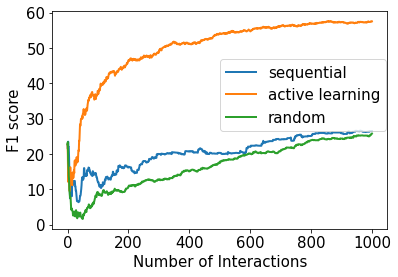

In [275]:
plt.rcParams.update({'font.size': 15})
d1["f1"].plot(linewidth=2, label="sequential")
d2["f1"].plot(linewidth=2, label="active learning")
d3["f1"].plot(linewidth=2, label="random")
#pd.Series([21.42]*(number_of_queries+1)).plot(linewidth=2, label="baseline")
plt.ylabel("F1 score")
plt.xlabel("Number of Interactions")
plt.legend(loc=(0.5,0.45))
plt.savefig('f1_score3.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

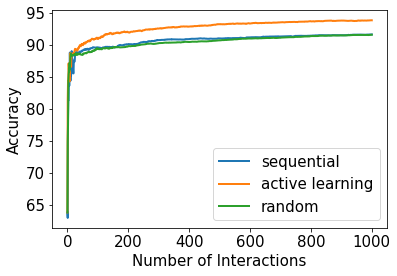

In [276]:
d1["accuracy"].plot(linewidth=2, label="sequential")
d2["accuracy"].plot(linewidth=2, label="active learning")
d3["accuracy"].plot(linewidth=2, label="random")
plt.ylabel("Accuracy")
plt.xlabel("Number of Interactions")
plt.legend()
plt.savefig('accuracy3.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

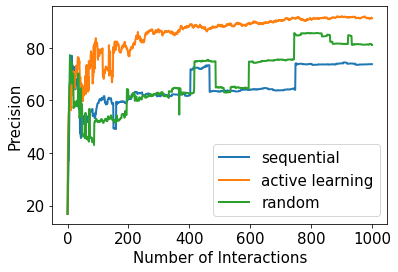

In [277]:
d1["precision"].plot(linewidth=2, label="sequential")
d2["precision"].plot(linewidth=2, label="active learning")
d3["precision"].plot(linewidth=2, label="random")
plt.ylabel("Precision")
plt.xlabel("Number of Interactions")
plt.legend()
plt.savefig('precision3.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

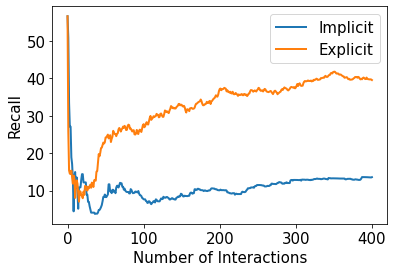

In [265]:
d1["recall"].plot(linewidth=2, label="Implicit")
d2["recall"].plot(linewidth=2, label="Explicit")
plt.ylabel("Recall")
plt.xlabel("Number of Interactions")
plt.legend()

In [223]:
for x,y in zip(X_lab, y_lab):
    print(x,y)

a 0
an 0
he 0
she 0
be 0
the 0
cat 0
dog 0
bat 0
mat 0
rat 0
graph 1
group 1
trivedi 1
green 1
grand 1
provost 1
crisp 1
grey 1
grill 1
crumble 1
torpor 0
dragon 1
globs 0
backgrounds 0
pioneered 0
premonition 1
scrubbed 0
prospectus 1
gravitate 1
torque 0
brother 1
screwdriver 0
bluebeard 0
granddaughters 1
blinds 0
trivialize 1
blas 0
predate 1
greenbelt 1
trends 1
carpenter 0
primarily 1
freight 1
frate 1
breakers 1
positron 0
promptly 1
carburetor 0
brainpower 1
drama 1
griscom 1
grimmest 1
predominant 1
pretending 1
lohengrin 0
sprinkler 0
transition 1
christiana 0
grossed 1
bizarre 0
profanity 1
plumbed 0
bro 1
tremors 1
shrug 0
bernhardt 0
cambrian 0
geriatric 0
quasar 0
printable 1
traitor 1
trailer 1
preschool 1
denmark 0
creature 1
breastplate 1
gravestone 1
preserving 1
ozarks 0
protruding 1
kristin 1
prophetic 1
brunet 1
brunette 1
drool 1
predators 1
groove 1
crier 1
procedures 1
protestors 1
protesters 1
cranky 1
blindness 0
darkly 0
clarke 0
clark 0
presiding 1
breeders 

In [224]:
len(X_lab), len(y_lab)

(121, 121)

In [225]:
clf.predict([lookup["BREW"]])[0]

1

In [192]:
oracle("trpor",0)

1

In [193]:
(2*0.12*1)/(1+0.12)

0.21428571428571425

In [233]:
str1 = "this7";  # No space & digit in this string
print(str1.isalpha()) # it gives return True

str2 = "this is 2";
print(str2.isalpha()) # it gives return False

False
False
